# Tel-Aviv Deep Learning Boot-camp: 12 Applied Deep Learning Labs

## Lab 0: Plant Seedlings Classification (PyTorch): The most basic lab :)  

<img src="assets/seedlings.png" align="center">

### Instructors:

- Shlomo Kashani: shlomo@bayesian.io ,
- Nathaniel Shimoni nathaniel.shimoni@grid4c.com 

<img src="assets/pt.jpg" width="35%" align="center">

## Progress

- [x] PyTorch DataSet
- [x] PyTorch DataLoader
- [x] Augmentations
- [x] Simple CNN
- [x] Training + train test split
- [x] TensorBoard Support from PyTorch
- [x] Accuray and Log Loss
- [x] Tqdm progress
- [x] Persisting the model
- [x] Testing on a test set



### Links:

- https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/ 
- Git: https://github.com/bayesianio/applied-dl-2018
- Full info: https://www.evernote.com/shard/s341/sh/3855640e-2b0b-42e5-b5b9-00216d02ac9a/b47968226e49a81ee813901cd41d3924

### Date and Location: 
- July 2018


### Requirements:
- Python 3.5, CUDA 9, cuDNN 7, PyTorch 2.0 or above, Keras 2 or above

#### For Windows 10 and Windows Server 2016, CUDA 9
`conda install -c peterjc123 pytorch cuda90`


### Data
- Download: https://www.kaggle.com/c/plant-seedlings-classification

- Please make sure you have already set up a Pytorch tree structure of your dataset:
- `data_dir= '/home/data/bone/train/' `

```
    data_dir= '/home/data/bone/train/
    
    ├── valid
    │   └── Type_1
        ├── Type_2
        └── Type_3
    └── train
        ├── Type_1
        ├── Type_2
        └── Type_3
```

### PyTorch Datasets

To create a dataset, we subclass Dataset and define a constructor, a `__len__` method, and a `__getitem__` method. 
Here is full example:

```python
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
        if self.transform:
            image = self.transform(image)
        return image, labels
```

### The PyTorch DataLoader Class¶
- Will load our BoneDataset
- Can be regarded as a list (or iterator, technically).
- Each time it is invoked will provide a minibatch of (img, label) pairs.


### Training with TensorBoard

With the aid of [Crayon](https://github.com/torrvision/crayon),
we can access the visualisation power of TensorBoard for any 
deep learning framework.

To use the TensorBoard, install Crayon (https://github.com/torrvision/crayon)
and set `use_tensorboard = True`


## Google Colab links:
- https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
- https://jovianlin.io/pytorch-with-gpu-in-google-colab/

In [2]:
# Google specific code

# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip3 install torchvision
# !pip3 install tqdm

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# !mkdir -p med-drive
# !google-drive-ocamlfuse med-drive

In [1]:
%reset -f 
%matplotlib inline


import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)



__Python VERSION: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
__pyTorch VERSION: 0.3.1.post2
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:32_Central_Daylight_Time_2017
Cuda compilation tools, release 9.0, V9.0.176
__CUDNN VERSION: 7003
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from kmodels import *
from kdataset import *

### Define Custom Dataset

In [3]:
import os
dataset='seedlings' # bone , cat-dog   d:/db/data/cat-dog/train/ ISIC2017
data_dir= 'd:/db/data/' +  dataset + '/train/'
# data_dir_valid= 'd:/db/data/' +  dataset + '/valid/'

classes, class_to_idx, num_to_class, df =GenericDataset.find_classes (data_dir )

print (classes)
print (class_to_idx)
print (num_to_class)
df.head(5)    

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


,file,category,category_id
0,Black-grass/0050f38b3.png,Black-grass,0
1,Black-grass/0183fdf68.png,Black-grass,0
2,Black-grass/0260cffa8.png,Black-grass,0
3,Black-grass/05eedce4d.png,Black-grass,0
4,Black-grass/075d004bc.png,Black-grass,0


In [4]:
len(classes)

12

# Target distribution : Train set

c:\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


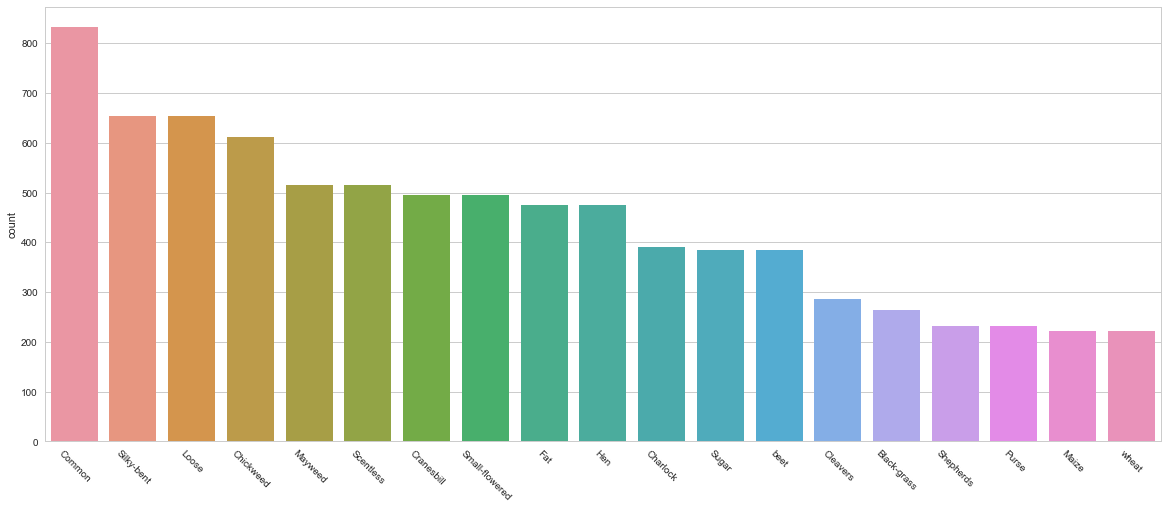

In [5]:
import seaborn as sns
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

labels = df['category'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

# Augmentation 

In [6]:
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

from ktransforms import *

## Setup transforms, datasets, and dataloaders

- Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.

{'train': 4038, 'valid': 712}
6     544
3     512
8     441
10    427
5     406
11    336
1     333
2     249
0     220
9     195
4     195
7     180
Name: category_id, dtype: int64


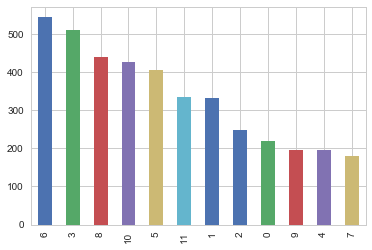

In [7]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 8
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())

train_data['category_id'].value_counts().plot(kind='bar')

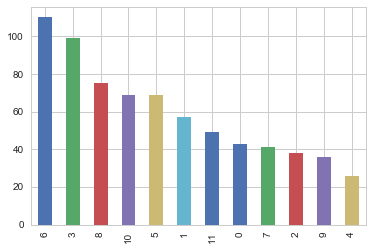

In [8]:
valid_data['category_id'].value_counts().plot(kind='bar')

### Test the DataLoader Class

i=0: 
i=1: 
i=2: 
i=3: 


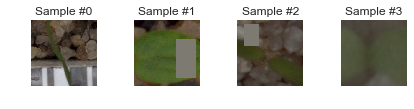

In [9]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    

if __name__ == '__main__':  
    for i, data in enumerate(t_loader, 0):
        print('i=%d: '%(i))            
        images, labels = data            
        num = len(images)

        ax = plt.subplot(1, imagesToShow, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        for n in range(num):
            image=images[n]
            label=labels[n]
            plt.imshow (flaotTensorToImage(image))

        if i==imagesToShow-1:
            break

## Define the model
- A simple CNN with great performance (95% accuracy) 
- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

`__init__:` constructor. Create layers here. Note that we don't define the connections between layers in this function.

`forward(x):` forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

# model = SimpleNet(len(classes), 3)
# model =vggnetXX_generic(len(classes), 3)
# model =lenetXX_generic(len(classes), 3)
# model =resnetxtXX_generic(len(classes), 3)
model =wrnXX_generic(len(classes), 3)
# model = senetXX_generic(len(classes), 3, 32)


criterion = torch.nn.CrossEntropyLoss()
lr= 0.00005 * 2 * 2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

if use_cuda:
    model = model.cuda()
# model = senetXX_generic(len(classes), 3, 32)
model_name = (type(model).__name__) # remember the real name
# model = torch.nn.DataParallel(model, device_ids=list(range(4)))
print(model)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (relu1): PReLU(num_parameters=1)
        (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu2): PReLU(num_parameters=1)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
  )
  (block2): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu1): PReLU(num_parameters=1)
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, 

# Metrics and Tensorboard

In [12]:
import datetime 

from utils import *

NOW_TIME = datetime.datetime.now()
NOW_TIME =NOW_TIME.strftime("%Y-%m-%d %H:%M")

use_tensorboard=False

hms_string(1000)

'0:16:40.00'

### Training

In [13]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 200  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 200== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))


def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

c:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
test_trans = valid_trans
test_data_dir = 'd:/db/data/seedlings/test/'

### Train the model

In [15]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.columns = ['file', 'species']
# sample_submission['category_id'] = 0
sample_submission.head(3)

if __name__ == '__main__':  
    epochs=150
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(95.0):            
            print ("EARLY STOP")            
            df_pred=testModel(test_data_dir,model)
            df_pred.to_csv(str(type(model).__name__) + '_' + str(val_accuracy) + '_' + 
                           str(epoch) + "_sub.csv", columns=('file', 'species'), index=None)
            torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        

Random Seed: 999
python version : 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
torch  version : 0.3.1.post2
cudnn  version : 7003
=> Final model name 'WideResNet'
MODEL: WideResNet
dataset: seedlings
    Total params: 1.80M
MODEL: WideResNet


  0%|                                                                                                                                                           | 0/150 [00:00<?, ?it/s]

TRAIN: LOSS-->2.6756 (2.6756)	ACC-->12.500% (12.500%)
TRAIN: 0 [0/4038 (0%)]	Loss: 2.675602, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->4.3554 (5.2598)	ACC-->0.000% (10.572%)
TRAIN: 0 [1600/4038 (40%)]	Loss: 4.355433, Accuracy: 0/8 (0.000%)
TRAIN: LOSS-->3.4634 (4.8617)	ACC-->12.500% (12.032%)
TRAIN: 0 [3200/4038 (79%)]	Loss: 3.463402, Accuracy: 1/8 (12.500%)
VAL:   LOSS--> 1.9424 (1.9424)	ACC-->37.500 (37.500)
 * Accuracy 27.5281


  1%|▉                                                                                                                                               | 1/150 [02:01<5:02:47, 121.93s/it]

TRAIN: LOSS-->2.9554 (2.9554)	ACC-->12.500% (12.500%)
TRAIN: 1 [0/4038 (0%)]	Loss: 2.955421, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->1.7255 (2.7127)	ACC-->50.000% (18.035%)
TRAIN: 1 [1600/4038 (40%)]	Loss: 1.725547, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->3.6606 (2.5562)	ACC-->25.000% (21.540%)
TRAIN: 1 [3200/4038 (79%)]	Loss: 3.660645, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 2.6335 (2.6335)	ACC-->25.000 (25.000)
 * Accuracy 46.3483


  1%|█▉                                                                                                                                              | 2/150 [03:55<4:50:41, 117.85s/it]

TRAIN: LOSS-->1.9370 (1.9370)	ACC-->25.000% (25.000%)
TRAIN: 2 [0/4038 (0%)]	Loss: 1.936955, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->2.2783 (2.2445)	ACC-->25.000% (28.980%)
TRAIN: 2 [1600/4038 (40%)]	Loss: 2.278316, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->2.1152 (2.1964)	ACC-->37.500% (29.520%)
TRAIN: 2 [3200/4038 (79%)]	Loss: 2.115176, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 2.1183 (2.1183)	ACC-->37.500 (37.500)
 * Accuracy 50.9831


  2%|██▉                                                                                                                                             | 3/150 [05:46<4:42:47, 115.43s/it]

TRAIN: LOSS-->2.6468 (2.6468)	ACC-->12.500% (12.500%)
TRAIN: 3 [0/4038 (0%)]	Loss: 2.646763, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->1.3548 (2.0420)	ACC-->75.000% (31.468%)
TRAIN: 3 [1600/4038 (40%)]	Loss: 1.354792, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->2.5655 (2.0578)	ACC-->12.500% (31.671%)
TRAIN: 3 [3200/4038 (79%)]	Loss: 2.565538, Accuracy: 1/8 (12.500%)
VAL:   LOSS--> 1.4037 (1.4037)	ACC-->62.500 (62.500)
 * Accuracy 55.4775


  3%|███▊                                                                                                                                            | 4/150 [07:36<4:37:33, 114.06s/it]

TRAIN: LOSS-->2.1632 (2.1632)	ACC-->12.500% (12.500%)
TRAIN: 4 [0/4038 (0%)]	Loss: 2.163244, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->1.7857 (2.0214)	ACC-->37.500% (33.644%)
TRAIN: 4 [1600/4038 (40%)]	Loss: 1.785748, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.9385 (1.9919)	ACC-->25.000% (34.320%)
TRAIN: 4 [3200/4038 (79%)]	Loss: 1.938523, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.8208 (1.8208)	ACC-->37.500 (37.500)
 * Accuracy 51.2640


  3%|████▊                                                                                                                                           | 5/150 [09:28<4:34:46, 113.70s/it]

TRAIN: LOSS-->1.4332 (1.4332)	ACC-->37.500% (37.500%)
TRAIN: 5 [0/4038 (0%)]	Loss: 1.433194, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.7884 (2.0433)	ACC-->25.000% (32.027%)
TRAIN: 5 [1600/4038 (40%)]	Loss: 1.788418, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.8397 (1.9426)	ACC-->25.000% (34.695%)
TRAIN: 5 [3200/4038 (79%)]	Loss: 1.839739, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.0323 (1.0323)	ACC-->87.500 (87.500)
 * Accuracy 50.5618


  4%|█████▊                                                                                                                                          | 6/150 [11:19<4:31:58, 113.32s/it]

TRAIN: LOSS-->2.0673 (2.0673)	ACC-->50.000% (50.000%)
TRAIN: 6 [0/4038 (0%)]	Loss: 2.067281, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.4584 (1.8552)	ACC-->25.000% (37.189%)
TRAIN: 6 [1600/4038 (40%)]	Loss: 1.458430, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.5161 (1.8599)	ACC-->50.000% (37.999%)
TRAIN: 6 [3200/4038 (79%)]	Loss: 1.516123, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 1.0788 (1.0788)	ACC-->75.000 (75.000)
 * Accuracy 55.6180


  5%|██████▋                                                                                                                                         | 7/150 [13:11<4:29:20, 113.01s/it]

TRAIN: LOSS-->2.8150 (2.8150)	ACC-->25.000% (25.000%)
TRAIN: 7 [0/4038 (0%)]	Loss: 2.814975, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.8564 (1.8769)	ACC-->25.000% (37.313%)
TRAIN: 7 [1600/4038 (40%)]	Loss: 1.856390, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.5237 (1.8431)	ACC-->62.500% (38.248%)
TRAIN: 7 [3200/4038 (79%)]	Loss: 1.523685, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 1.4758 (1.4758)	ACC-->50.000 (50.000)
 * Accuracy 58.9888


  5%|███████▋                                                                                                                                        | 8/150 [15:01<4:26:34, 112.64s/it]

TRAIN: LOSS-->1.8913 (1.8913)	ACC-->37.500% (37.500%)
TRAIN: 8 [0/4038 (0%)]	Loss: 1.891336, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.7974 (1.8322)	ACC-->37.500% (38.308%)
TRAIN: 8 [1600/4038 (40%)]	Loss: 1.797388, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.6783 (1.8438)	ACC-->37.500% (38.934%)
TRAIN: 8 [3200/4038 (79%)]	Loss: 1.678296, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.9511 (0.9511)	ACC-->87.500 (87.500)
 * Accuracy 61.2360


  6%|████████▋                                                                                                                                       | 9/150 [16:52<4:24:14, 112.44s/it]

TRAIN: LOSS-->2.9911 (2.9911)	ACC-->25.000% (25.000%)
TRAIN: 9 [0/4038 (0%)]	Loss: 2.991076, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.6665 (1.8742)	ACC-->37.500% (38.246%)
TRAIN: 9 [1600/4038 (40%)]	Loss: 1.666546, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->2.2458 (1.8358)	ACC-->37.500% (39.464%)
TRAIN: 9 [3200/4038 (79%)]	Loss: 2.245814, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.8628 (0.8628)	ACC-->75.000 (75.000)
 * Accuracy 52.9494


  7%|█████████▌                                                                                                                                     | 10/150 [18:43<4:22:08, 112.35s/it]

TRAIN: LOSS-->2.5949 (2.5949)	ACC-->25.000% (25.000%)
TRAIN: 10 [0/4038 (0%)]	Loss: 2.594947, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.6428 (1.8367)	ACC-->25.000% (36.381%)
TRAIN: 10 [1600/4038 (40%)]	Loss: 1.642753, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.7417 (1.8209)	ACC-->50.000% (38.279%)
TRAIN: 10 [3200/4038 (79%)]	Loss: 1.741724, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 1.2750 (1.2750)	ACC-->87.500 (87.500)
 * Accuracy 59.9719


  7%|██████████▍                                                                                                                                    | 11/150 [20:35<4:20:10, 112.30s/it]

TRAIN: LOSS-->1.6995 (1.6995)	ACC-->37.500% (37.500%)
TRAIN: 11 [0/4038 (0%)]	Loss: 1.699544, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.8014 (1.7568)	ACC-->25.000% (41.604%)
TRAIN: 11 [1600/4038 (40%)]	Loss: 1.801449, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.9593 (1.7553)	ACC-->25.000% (41.490%)
TRAIN: 11 [3200/4038 (79%)]	Loss: 1.959250, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.2949 (1.2949)	ACC-->62.500 (62.500)
 * Accuracy 61.2360


  8%|███████████▍                                                                                                                                   | 12/150 [22:25<4:17:57, 112.16s/it]

TRAIN: LOSS-->1.8802 (1.8802)	ACC-->37.500% (37.500%)
TRAIN: 12 [0/4038 (0%)]	Loss: 1.880241, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.6193 (1.8087)	ACC-->37.500% (41.231%)
TRAIN: 12 [1600/4038 (40%)]	Loss: 1.619322, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.7049 (1.7718)	ACC-->62.500% (42.051%)
TRAIN: 12 [3200/4038 (79%)]	Loss: 1.704916, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.5338 (0.5338)	ACC-->87.500 (87.500)
 * Accuracy 58.0056


  9%|████████████▍                                                                                                                                  | 13/150 [24:16<4:15:45, 112.01s/it]

TRAIN: LOSS-->1.7026 (1.7026)	ACC-->37.500% (37.500%)
TRAIN: 13 [0/4038 (0%)]	Loss: 1.702638, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.3857 (1.7844)	ACC-->62.500% (40.547%)
TRAIN: 13 [1600/4038 (40%)]	Loss: 1.385705, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->2.5410 (1.7531)	ACC-->25.000% (41.708%)
TRAIN: 13 [3200/4038 (79%)]	Loss: 2.540990, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.2672 (1.2672)	ACC-->50.000 (50.000)
 * Accuracy 60.3933


  9%|█████████████▎                                                                                                                                 | 14/150 [26:07<4:13:44, 111.94s/it]

TRAIN: LOSS-->1.9580 (1.9580)	ACC-->25.000% (25.000%)
TRAIN: 14 [0/4038 (0%)]	Loss: 1.957969, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.2505 (1.7041)	ACC-->62.500% (45.274%)
TRAIN: 14 [1600/4038 (40%)]	Loss: 1.250481, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.5447 (1.6946)	ACC-->37.500% (44.327%)
TRAIN: 14 [3200/4038 (79%)]	Loss: 1.544736, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.7933 (0.7933)	ACC-->100.000 (100.000)
 * Accuracy 62.7809


 10%|██████████████▎                                                                                                                                | 15/150 [27:57<4:11:33, 111.80s/it]

TRAIN: LOSS-->1.9111 (1.9111)	ACC-->37.500% (37.500%)
TRAIN: 15 [0/4038 (0%)]	Loss: 1.911055, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.2014 (1.7131)	ACC-->50.000% (45.585%)
TRAIN: 15 [1600/4038 (40%)]	Loss: 1.201414, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.3895 (1.7106)	ACC-->62.500% (44.825%)
TRAIN: 15 [3200/4038 (79%)]	Loss: 1.389532, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 1.0153 (1.0153)	ACC-->62.500 (62.500)
 * Accuracy 61.0955


 11%|███████████████▎                                                                                                                               | 16/150 [29:47<4:09:26, 111.69s/it]

TRAIN: LOSS-->1.5227 (1.5227)	ACC-->62.500% (62.500%)
TRAIN: 16 [0/4038 (0%)]	Loss: 1.522723, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2866 (1.7127)	ACC-->37.500% (45.460%)
TRAIN: 16 [1600/4038 (40%)]	Loss: 1.286615, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.7588 (1.7046)	ACC-->50.000% (44.857%)
TRAIN: 16 [3200/4038 (79%)]	Loss: 1.758812, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.9569 (0.9569)	ACC-->75.000 (75.000)
 * Accuracy 62.6404


 11%|████████████████▏                                                                                                                              | 17/150 [31:36<4:07:18, 111.57s/it]

TRAIN: LOSS-->1.6629 (1.6629)	ACC-->37.500% (37.500%)
TRAIN: 17 [0/4038 (0%)]	Loss: 1.662883, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->2.7537 (1.6243)	ACC-->37.500% (47.139%)
TRAIN: 17 [1600/4038 (40%)]	Loss: 2.753724, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->2.0995 (1.6413)	ACC-->37.500% (46.384%)
TRAIN: 17 [3200/4038 (79%)]	Loss: 2.099478, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 1.3517 (1.3517)	ACC-->62.500 (62.500)
 * Accuracy 63.9045


 12%|█████████████████▏                                                                                                                             | 18/150 [33:26<4:05:13, 111.46s/it]

TRAIN: LOSS-->1.4432 (1.4432)	ACC-->62.500% (62.500%)
TRAIN: 18 [0/4038 (0%)]	Loss: 1.443236, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.3506 (1.6456)	ACC-->50.000% (45.709%)
TRAIN: 18 [1600/4038 (40%)]	Loss: 1.350620, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.3008 (1.6237)	ACC-->62.500% (46.384%)
TRAIN: 18 [3200/4038 (79%)]	Loss: 1.300752, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 1.2025 (1.2025)	ACC-->62.500 (62.500)
 * Accuracy 70.3652


 13%|██████████████████                                                                                                                             | 19/150 [35:16<4:03:09, 111.37s/it]

TRAIN: LOSS-->1.8095 (1.8095)	ACC-->50.000% (50.000%)
TRAIN: 19 [0/4038 (0%)]	Loss: 1.809454, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.8586 (1.6105)	ACC-->50.000% (46.393%)
TRAIN: 19 [1600/4038 (40%)]	Loss: 1.858575, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.8410 (1.6252)	ACC-->25.000% (46.415%)
TRAIN: 19 [3200/4038 (79%)]	Loss: 1.841037, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 0.9251 (0.9251)	ACC-->75.000 (75.000)
 * Accuracy 64.8876


 13%|███████████████████                                                                                                                            | 20/150 [37:05<4:01:08, 111.29s/it]

TRAIN: LOSS-->1.9514 (1.9514)	ACC-->25.000% (25.000%)
TRAIN: 20 [0/4038 (0%)]	Loss: 1.951396, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->2.3767 (1.6353)	ACC-->12.500% (46.455%)
TRAIN: 20 [1600/4038 (40%)]	Loss: 2.376678, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->1.6366 (1.6167)	ACC-->50.000% (46.945%)
TRAIN: 20 [3200/4038 (79%)]	Loss: 1.636617, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.9313 (0.9313)	ACC-->75.000 (75.000)
 * Accuracy 69.1011


 14%|████████████████████                                                                                                                           | 21/150 [38:55<3:59:07, 111.22s/it]

TRAIN: LOSS-->1.1144 (1.1144)	ACC-->62.500% (62.500%)
TRAIN: 21 [0/4038 (0%)]	Loss: 1.114378, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7618 (1.5658)	ACC-->75.000% (47.823%)
TRAIN: 21 [1600/4038 (40%)]	Loss: 0.761827, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.5956 (1.5424)	ACC-->50.000% (49.532%)
TRAIN: 21 [3200/4038 (79%)]	Loss: 1.595585, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.8392 (0.8392)	ACC-->62.500 (62.500)
 * Accuracy 63.0618


 15%|████████████████████▉                                                                                                                          | 22/150 [40:45<3:57:08, 111.16s/it]

TRAIN: LOSS-->1.3388 (1.3388)	ACC-->50.000% (50.000%)
TRAIN: 22 [0/4038 (0%)]	Loss: 1.338774, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.0086 (1.5691)	ACC-->62.500% (48.818%)
TRAIN: 22 [1600/4038 (40%)]	Loss: 1.008642, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.6899 (1.5661)	ACC-->25.000% (48.722%)
TRAIN: 22 [3200/4038 (79%)]	Loss: 1.689944, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 0.9289 (0.9289)	ACC-->75.000 (75.000)
 * Accuracy 71.0674


 15%|█████████████████████▉                                                                                                                         | 23/150 [42:35<3:55:09, 111.10s/it]

TRAIN: LOSS-->1.7017 (1.7017)	ACC-->50.000% (50.000%)
TRAIN: 23 [0/4038 (0%)]	Loss: 1.701701, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.9730 (1.5490)	ACC-->12.500% (51.555%)
TRAIN: 23 [1600/4038 (40%)]	Loss: 1.972972, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->1.2689 (1.5193)	ACC-->75.000% (51.870%)
TRAIN: 23 [3200/4038 (79%)]	Loss: 1.268925, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.9416 (0.9416)	ACC-->75.000 (75.000)
 * Accuracy 74.0169


 16%|██████████████████████▉                                                                                                                        | 24/150 [44:25<3:53:11, 111.05s/it]

TRAIN: LOSS-->1.2011 (1.2011)	ACC-->37.500% (37.500%)
TRAIN: 24 [0/4038 (0%)]	Loss: 1.201117, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->2.1972 (1.4817)	ACC-->37.500% (51.928%)
TRAIN: 24 [1600/4038 (40%)]	Loss: 2.197181, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.5783 (1.4912)	ACC-->37.500% (52.307%)
TRAIN: 24 [3200/4038 (79%)]	Loss: 1.578329, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.7944 (0.7944)	ACC-->62.500 (62.500)
 * Accuracy 70.6461


 17%|███████████████████████▊                                                                                                                       | 25/150 [46:14<3:51:13, 110.99s/it]

TRAIN: LOSS-->1.1322 (1.1322)	ACC-->75.000% (75.000%)
TRAIN: 25 [0/4038 (0%)]	Loss: 1.132218, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9994 (1.5122)	ACC-->62.500% (50.311%)
TRAIN: 25 [1600/4038 (40%)]	Loss: 0.999404, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.3551 (1.4761)	ACC-->50.000% (51.403%)
TRAIN: 25 [3200/4038 (79%)]	Loss: 1.355065, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.5381 (0.5381)	ACC-->100.000 (100.000)
 * Accuracy 68.9607


 17%|████████████████████████▊                                                                                                                      | 26/150 [48:04<3:49:16, 110.94s/it]

TRAIN: LOSS-->1.0498 (1.0498)	ACC-->62.500% (62.500%)
TRAIN: 26 [0/4038 (0%)]	Loss: 1.049838, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.3191 (1.4165)	ACC-->37.500% (53.731%)
TRAIN: 26 [1600/4038 (40%)]	Loss: 1.319078, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.8717 (1.4471)	ACC-->62.500% (52.899%)
TRAIN: 26 [3200/4038 (79%)]	Loss: 0.871729, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.9502 (0.9502)	ACC-->75.000 (75.000)
 * Accuracy 72.6124


 18%|█████████████████████████▋                                                                                                                     | 27/150 [49:54<3:47:20, 110.90s/it]

TRAIN: LOSS-->1.3144 (1.3144)	ACC-->50.000% (50.000%)
TRAIN: 27 [0/4038 (0%)]	Loss: 1.314397, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.1487 (1.4406)	ACC-->50.000% (53.856%)
TRAIN: 27 [1600/4038 (40%)]	Loss: 1.148680, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.7284 (1.4250)	ACC-->37.500% (54.364%)
TRAIN: 27 [3200/4038 (79%)]	Loss: 1.728392, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.6888 (0.6888)	ACC-->100.000 (100.000)
 * Accuracy 78.6517


 19%|██████████████████████████▋                                                                                                                    | 28/150 [51:44<3:45:25, 110.86s/it]

TRAIN: LOSS-->1.7640 (1.7640)	ACC-->37.500% (37.500%)
TRAIN: 28 [0/4038 (0%)]	Loss: 1.763999, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.8611 (1.4300)	ACC-->75.000% (53.358%)
TRAIN: 28 [1600/4038 (40%)]	Loss: 0.861116, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.3938 (1.4010)	ACC-->50.000% (55.362%)
TRAIN: 28 [3200/4038 (79%)]	Loss: 1.393808, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.4897 (0.4897)	ACC-->87.500 (87.500)
 * Accuracy 73.5955


 19%|███████████████████████████▋                                                                                                                   | 29/150 [53:33<3:43:30, 110.83s/it]

TRAIN: LOSS-->1.4003 (1.4003)	ACC-->62.500% (62.500%)
TRAIN: 29 [0/4038 (0%)]	Loss: 1.400255, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.5693 (1.4418)	ACC-->50.000% (53.234%)
TRAIN: 29 [1600/4038 (40%)]	Loss: 1.569252, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.1133 (1.3983)	ACC-->62.500% (54.177%)
TRAIN: 29 [3200/4038 (79%)]	Loss: 1.113348, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.6779 (0.6779)	ACC-->75.000 (75.000)
 * Accuracy 80.8989


 20%|████████████████████████████▌                                                                                                                  | 30/150 [55:23<3:41:35, 110.79s/it]

TRAIN: LOSS-->1.2453 (1.2453)	ACC-->62.500% (62.500%)
TRAIN: 30 [0/4038 (0%)]	Loss: 1.245311, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9441 (1.4122)	ACC-->62.500% (53.980%)
TRAIN: 30 [1600/4038 (40%)]	Loss: 0.944121, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1402 (1.3763)	ACC-->62.500% (55.299%)
TRAIN: 30 [3200/4038 (79%)]	Loss: 1.140218, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 1.1223 (1.1223)	ACC-->50.000 (50.000)
 * Accuracy 78.0899


 21%|█████████████████████████████▌                                                                                                                 | 31/150 [57:13<3:39:40, 110.76s/it]

TRAIN: LOSS-->0.9340 (0.9340)	ACC-->75.000% (75.000%)
TRAIN: 31 [0/4038 (0%)]	Loss: 0.933951, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.5799 (1.3284)	ACC-->50.000% (56.903%)
TRAIN: 31 [1600/4038 (40%)]	Loss: 1.579950, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.4561 (1.3458)	ACC-->62.500% (56.266%)
TRAIN: 31 [3200/4038 (79%)]	Loss: 1.456142, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4945 (0.4945)	ACC-->87.500 (87.500)
 * Accuracy 73.5955


 21%|██████████████████████████████▌                                                                                                                | 32/150 [59:03<3:37:45, 110.72s/it]

TRAIN: LOSS-->1.9964 (1.9964)	ACC-->50.000% (50.000%)
TRAIN: 32 [0/4038 (0%)]	Loss: 1.996351, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.0470 (1.3600)	ACC-->62.500% (55.410%)
TRAIN: 32 [1600/4038 (40%)]	Loss: 1.046981, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9821 (1.3291)	ACC-->75.000% (57.544%)
TRAIN: 32 [3200/4038 (79%)]	Loss: 0.982083, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.6970 (0.6970)	ACC-->87.500 (87.500)
 * Accuracy 76.2640


 22%|███████████████████████████████                                                                                                              | 33/150 [1:00:52<3:35:51, 110.70s/it]

TRAIN: LOSS-->1.3085 (1.3085)	ACC-->75.000% (75.000%)
TRAIN: 33 [0/4038 (0%)]	Loss: 1.308500, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9207 (1.3049)	ACC-->62.500% (57.525%)
TRAIN: 33 [1600/4038 (40%)]	Loss: 0.920727, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8180 (1.3006)	ACC-->75.000% (58.416%)
TRAIN: 33 [3200/4038 (79%)]	Loss: 0.817997, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.6009 (0.6009)	ACC-->87.500 (87.500)
 * Accuracy 80.3371


 23%|███████████████████████████████▉                                                                                                             | 34/150 [1:02:42<3:33:57, 110.67s/it]

TRAIN: LOSS-->1.6357 (1.6357)	ACC-->62.500% (62.500%)
TRAIN: 34 [0/4038 (0%)]	Loss: 1.635653, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2548 (1.3036)	ACC-->50.000% (59.391%)
TRAIN: 34 [1600/4038 (40%)]	Loss: 1.254778, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7285 (1.2858)	ACC-->75.000% (59.570%)
TRAIN: 34 [3200/4038 (79%)]	Loss: 0.728478, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.5563 (0.5563)	ACC-->87.500 (87.500)
 * Accuracy 72.4719


 23%|████████████████████████████████▉                                                                                                            | 35/150 [1:04:32<3:32:03, 110.64s/it]

TRAIN: LOSS-->1.0714 (1.0714)	ACC-->75.000% (75.000%)
TRAIN: 35 [0/4038 (0%)]	Loss: 1.071352, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7410 (1.2747)	ACC-->87.500% (59.328%)
TRAIN: 35 [1600/4038 (40%)]	Loss: 0.740983, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.0004 (1.2906)	ACC-->87.500% (58.011%)
TRAIN: 35 [3200/4038 (79%)]	Loss: 1.000370, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.7328 (0.7328)	ACC-->87.500 (87.500)
 * Accuracy 77.8090


 24%|█████████████████████████████████▊                                                                                                           | 36/150 [1:06:22<3:30:11, 110.62s/it]

TRAIN: LOSS-->1.5893 (1.5893)	ACC-->62.500% (62.500%)
TRAIN: 36 [0/4038 (0%)]	Loss: 1.589292, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.4818 (1.2452)	ACC-->37.500% (59.515%)
TRAIN: 36 [1600/4038 (40%)]	Loss: 1.481809, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.1315 (1.2558)	ACC-->62.500% (58.354%)
TRAIN: 36 [3200/4038 (79%)]	Loss: 1.131538, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.6495 (0.6495)	ACC-->87.500 (87.500)
 * Accuracy 82.3034


 25%|██████████████████████████████████▊                                                                                                          | 37/150 [1:08:12<3:28:17, 110.60s/it]

TRAIN: LOSS-->1.9439 (1.9439)	ACC-->25.000% (25.000%)
TRAIN: 37 [0/4038 (0%)]	Loss: 1.943949, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.0594 (1.2347)	ACC-->62.500% (61.692%)
TRAIN: 37 [1600/4038 (40%)]	Loss: 1.059422, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6788 (1.2436)	ACC-->75.000% (60.817%)
TRAIN: 37 [3200/4038 (79%)]	Loss: 0.678790, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4548 (0.4548)	ACC-->87.500 (87.500)
 * Accuracy 82.7247


 25%|███████████████████████████████████▋                                                                                                         | 38/150 [1:10:01<3:26:24, 110.58s/it]

TRAIN: LOSS-->1.0424 (1.0424)	ACC-->50.000% (50.000%)
TRAIN: 38 [0/4038 (0%)]	Loss: 1.042374, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.3779 (1.2277)	ACC-->37.500% (59.142%)
TRAIN: 38 [1600/4038 (40%)]	Loss: 1.377865, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.4228 (1.2013)	ACC-->50.000% (61.128%)
TRAIN: 38 [3200/4038 (79%)]	Loss: 1.422752, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.4313 (0.4313)	ACC-->100.000 (100.000)
 * Accuracy 74.0169


 26%|████████████████████████████████████▋                                                                                                        | 39/150 [1:11:51<3:24:31, 110.55s/it]

TRAIN: LOSS-->2.1914 (2.1914)	ACC-->37.500% (37.500%)
TRAIN: 39 [0/4038 (0%)]	Loss: 2.191367, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.2864 (1.1958)	ACC-->62.500% (62.749%)
TRAIN: 39 [1600/4038 (40%)]	Loss: 1.286400, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7641 (1.1971)	ACC-->75.000% (61.534%)
TRAIN: 39 [3200/4038 (79%)]	Loss: 0.764078, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.8800 (0.8800)	ACC-->62.500 (62.500)
 * Accuracy 81.8820


 27%|█████████████████████████████████████▌                                                                                                       | 40/150 [1:13:41<3:22:38, 110.53s/it]

TRAIN: LOSS-->0.5993 (0.5993)	ACC-->87.500% (87.500%)
TRAIN: 40 [0/4038 (0%)]	Loss: 0.599250, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.6115 (1.1461)	ACC-->50.000% (62.376%)
TRAIN: 40 [1600/4038 (40%)]	Loss: 1.611525, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4045 (1.1573)	ACC-->87.500% (62.406%)
TRAIN: 40 [3200/4038 (79%)]	Loss: 0.404499, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.6315 (0.6315)	ACC-->87.500 (87.500)
 * Accuracy 79.9157


 27%|██████████████████████████████████████▌                                                                                                      | 41/150 [1:15:31<3:20:45, 110.51s/it]

TRAIN: LOSS-->1.2667 (1.2667)	ACC-->87.500% (87.500%)
TRAIN: 41 [0/4038 (0%)]	Loss: 1.266714, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.2006 (1.2000)	ACC-->62.500% (62.002%)
TRAIN: 41 [1600/4038 (40%)]	Loss: 1.200649, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5868 (1.2013)	ACC-->87.500% (61.658%)
TRAIN: 41 [3200/4038 (79%)]	Loss: 0.586826, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.4989 (0.4989)	ACC-->75.000 (75.000)
 * Accuracy 79.6348


 28%|███████████████████████████████████████▍                                                                                                     | 42/150 [1:17:20<3:18:53, 110.49s/it]

TRAIN: LOSS-->1.9704 (1.9704)	ACC-->37.500% (37.500%)
TRAIN: 42 [0/4038 (0%)]	Loss: 1.970370, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.6626 (1.1545)	ACC-->37.500% (64.552%)
TRAIN: 42 [1600/4038 (40%)]	Loss: 1.662573, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.9951 (1.1189)	ACC-->75.000% (64.776%)
TRAIN: 42 [3200/4038 (79%)]	Loss: 0.995149, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4681 (0.4681)	ACC-->100.000 (100.000)
 * Accuracy 80.7584


 29%|████████████████████████████████████████▍                                                                                                    | 43/150 [1:19:10<3:17:00, 110.47s/it]

TRAIN: LOSS-->1.6250 (1.6250)	ACC-->62.500% (62.500%)
TRAIN: 43 [0/4038 (0%)]	Loss: 1.625012, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7362 (1.1229)	ACC-->87.500% (63.184%)
TRAIN: 43 [1600/4038 (40%)]	Loss: 0.736152, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.3658 (1.1378)	ACC-->37.500% (62.936%)
TRAIN: 43 [3200/4038 (79%)]	Loss: 1.365843, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.3754 (0.3754)	ACC-->75.000 (75.000)
 * Accuracy 83.1461


 29%|█████████████████████████████████████████▎                                                                                                   | 44/150 [1:21:00<3:15:08, 110.46s/it]

TRAIN: LOSS-->1.6091 (1.6091)	ACC-->62.500% (62.500%)
TRAIN: 44 [0/4038 (0%)]	Loss: 1.609122, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.4302 (1.1377)	ACC-->37.500% (63.246%)
TRAIN: 44 [1600/4038 (40%)]	Loss: 1.430162, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6644 (1.1048)	ACC-->87.500% (64.931%)
TRAIN: 44 [3200/4038 (79%)]	Loss: 0.664371, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3741 (0.3741)	ACC-->87.500 (87.500)
 * Accuracy 86.0955


 30%|██████████████████████████████████████████▎                                                                                                  | 45/150 [1:22:50<3:13:16, 110.45s/it]

TRAIN: LOSS-->0.8730 (0.8730)	ACC-->50.000% (50.000%)
TRAIN: 45 [0/4038 (0%)]	Loss: 0.872981, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4751 (1.0725)	ACC-->75.000% (66.045%)
TRAIN: 45 [1600/4038 (40%)]	Loss: 0.475145, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8582 (1.0693)	ACC-->50.000% (65.274%)
TRAIN: 45 [3200/4038 (79%)]	Loss: 0.858178, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.3832 (0.3832)	ACC-->75.000 (75.000)
 * Accuracy 85.6742


 31%|███████████████████████████████████████████▏                                                                                                 | 46/150 [1:24:39<3:11:24, 110.43s/it]

TRAIN: LOSS-->1.1868 (1.1868)	ACC-->50.000% (50.000%)
TRAIN: 46 [0/4038 (0%)]	Loss: 1.186811, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7329 (1.1087)	ACC-->75.000% (65.672%)
TRAIN: 46 [1600/4038 (40%)]	Loss: 0.732911, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8564 (1.0902)	ACC-->87.500% (65.835%)
TRAIN: 46 [3200/4038 (79%)]	Loss: 0.856376, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.5757 (0.5757)	ACC-->62.500 (62.500)
 * Accuracy 82.1629


 31%|████████████████████████████████████████████▏                                                                                                | 47/150 [1:26:29<3:09:32, 110.41s/it]

TRAIN: LOSS-->1.6135 (1.6135)	ACC-->37.500% (37.500%)
TRAIN: 47 [0/4038 (0%)]	Loss: 1.613522, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.8499 (1.0330)	ACC-->37.500% (66.729%)
TRAIN: 47 [1600/4038 (40%)]	Loss: 1.849906, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6929 (1.0531)	ACC-->75.000% (65.305%)
TRAIN: 47 [3200/4038 (79%)]	Loss: 0.692888, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3824 (0.3824)	ACC-->100.000 (100.000)
 * Accuracy 85.2528


 32%|█████████████████████████████████████████████                                                                                                | 48/150 [1:28:19<3:07:41, 110.41s/it]

TRAIN: LOSS-->1.0103 (1.0103)	ACC-->50.000% (50.000%)
TRAIN: 48 [0/4038 (0%)]	Loss: 1.010308, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.9333 (1.0761)	ACC-->62.500% (66.294%)
TRAIN: 48 [1600/4038 (40%)]	Loss: 0.933313, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5448 (1.0687)	ACC-->75.000% (66.272%)
TRAIN: 48 [3200/4038 (79%)]	Loss: 0.544765, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4913 (0.4913)	ACC-->75.000 (75.000)
 * Accuracy 87.0787


 33%|██████████████████████████████████████████████                                                                                               | 49/150 [1:30:09<3:05:50, 110.40s/it]

TRAIN: LOSS-->2.6112 (2.6112)	ACC-->37.500% (37.500%)
TRAIN: 49 [0/4038 (0%)]	Loss: 2.611186, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.1040 (1.0744)	ACC-->50.000% (64.614%)
TRAIN: 49 [1600/4038 (40%)]	Loss: 1.104018, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.1629 (1.0470)	ACC-->37.500% (66.397%)
TRAIN: 49 [3200/4038 (79%)]	Loss: 1.162908, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.6692 (0.6692)	ACC-->62.500 (62.500)
 * Accuracy 83.5674


 33%|███████████████████████████████████████████████                                                                                              | 50/150 [1:31:59<3:03:58, 110.39s/it]

TRAIN: LOSS-->0.8708 (0.8708)	ACC-->75.000% (75.000%)
TRAIN: 50 [0/4038 (0%)]	Loss: 0.870754, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7208 (1.0450)	ACC-->62.500% (67.164%)
TRAIN: 50 [1600/4038 (40%)]	Loss: 0.720774, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2471 (1.0439)	ACC-->62.500% (67.113%)
TRAIN: 50 [3200/4038 (79%)]	Loss: 1.247139, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2790 (0.2790)	ACC-->87.500 (87.500)
 * Accuracy 88.6236


 34%|███████████████████████████████████████████████▉                                                                                             | 51/150 [1:33:49<3:02:07, 110.38s/it]

TRAIN: LOSS-->1.1084 (1.1084)	ACC-->87.500% (87.500%)
TRAIN: 51 [0/4038 (0%)]	Loss: 1.108401, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9059 (1.0244)	ACC-->62.500% (67.040%)
TRAIN: 51 [1600/4038 (40%)]	Loss: 0.905898, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8384 (1.0303)	ACC-->62.500% (67.082%)
TRAIN: 51 [3200/4038 (79%)]	Loss: 0.838398, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.5891 (0.5891)	ACC-->62.500 (62.500)
 * Accuracy 84.8315


 35%|████████████████████████████████████████████████▉                                                                                            | 52/150 [1:35:38<3:00:15, 110.36s/it]

TRAIN: LOSS-->0.7180 (0.7180)	ACC-->75.000% (75.000%)
TRAIN: 52 [0/4038 (0%)]	Loss: 0.717982, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.6958 (1.0024)	ACC-->37.500% (67.724%)
TRAIN: 52 [1600/4038 (40%)]	Loss: 1.695833, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.5883 (1.0069)	ACC-->75.000% (67.924%)
TRAIN: 52 [3200/4038 (79%)]	Loss: 0.588257, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 1.1364 (1.1364)	ACC-->50.000 (50.000)
 * Accuracy 90.0281


 35%|█████████████████████████████████████████████████▊                                                                                           | 53/150 [1:37:28<2:58:24, 110.35s/it]

TRAIN: LOSS-->1.1047 (1.1047)	ACC-->62.500% (62.500%)
TRAIN: 53 [0/4038 (0%)]	Loss: 1.104696, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8409 (0.9839)	ACC-->75.000% (66.729%)
TRAIN: 53 [1600/4038 (40%)]	Loss: 0.840912, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7863 (0.9976)	ACC-->75.000% (66.584%)
TRAIN: 53 [3200/4038 (79%)]	Loss: 0.786347, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4504 (0.4504)	ACC-->87.500 (87.500)
 * Accuracy 87.2191


 36%|██████████████████████████████████████████████████▊                                                                                          | 54/150 [1:39:18<2:56:32, 110.34s/it]

TRAIN: LOSS-->1.6830 (1.6830)	ACC-->37.500% (37.500%)
TRAIN: 54 [0/4038 (0%)]	Loss: 1.682985, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.4549 (1.0399)	ACC-->37.500% (66.978%)
TRAIN: 54 [1600/4038 (40%)]	Loss: 1.454858, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.5781 (1.0064)	ACC-->87.500% (68.329%)
TRAIN: 54 [3200/4038 (79%)]	Loss: 0.578057, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.4855 (0.4855)	ACC-->87.500 (87.500)
 * Accuracy 86.0955


 37%|███████████████████████████████████████████████████▋                                                                                         | 55/150 [1:41:08<2:54:41, 110.33s/it]

TRAIN: LOSS-->1.3912 (1.3912)	ACC-->62.500% (62.500%)
TRAIN: 55 [0/4038 (0%)]	Loss: 1.391194, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1198 (0.9412)	ACC-->75.000% (69.092%)
TRAIN: 55 [1600/4038 (40%)]	Loss: 1.119792, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2788 (0.9624)	ACC-->62.500% (68.859%)
TRAIN: 55 [3200/4038 (79%)]	Loss: 1.278844, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1342 (0.1342)	ACC-->100.000 (100.000)
 * Accuracy 89.7472


 37%|████████████████████████████████████████████████████▋                                                                                        | 56/150 [1:42:58<2:52:50, 110.32s/it]

TRAIN: LOSS-->0.8041 (0.8041)	ACC-->62.500% (62.500%)
TRAIN: 56 [0/4038 (0%)]	Loss: 0.804064, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1340 (0.9300)	ACC-->62.500% (70.025%)
TRAIN: 56 [1600/4038 (40%)]	Loss: 1.134040, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.4327 (0.9310)	ACC-->75.000% (70.231%)
TRAIN: 56 [3200/4038 (79%)]	Loss: 1.432747, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.7552 (0.7552)	ACC-->87.500 (87.500)
 * Accuracy 90.3090


 38%|█████████████████████████████████████████████████████▌                                                                                       | 57/150 [1:44:47<2:50:59, 110.31s/it]

TRAIN: LOSS-->0.9526 (0.9526)	ACC-->62.500% (62.500%)
TRAIN: 57 [0/4038 (0%)]	Loss: 0.952578, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1357 (0.9289)	ACC-->75.000% (71.206%)
TRAIN: 57 [1600/4038 (40%)]	Loss: 1.135734, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5151 (0.9354)	ACC-->87.500% (70.574%)
TRAIN: 57 [3200/4038 (79%)]	Loss: 0.515130, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.8031 (0.8031)	ACC-->75.000 (75.000)
 * Accuracy 87.2191


 39%|██████████████████████████████████████████████████████▌                                                                                      | 58/150 [1:46:37<2:49:08, 110.31s/it]

TRAIN: LOSS-->0.8754 (0.8754)	ACC-->50.000% (50.000%)
TRAIN: 58 [0/4038 (0%)]	Loss: 0.875365, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.9856 (0.9098)	ACC-->75.000% (71.144%)
TRAIN: 58 [1600/4038 (40%)]	Loss: 0.985598, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8131 (0.9306)	ACC-->87.500% (70.480%)
TRAIN: 58 [3200/4038 (79%)]	Loss: 0.813056, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.5501 (0.5501)	ACC-->75.000 (75.000)
 * Accuracy 89.6067


 39%|███████████████████████████████████████████████████████▍                                                                                     | 59/150 [1:48:27<2:47:17, 110.30s/it]

TRAIN: LOSS-->0.1670 (0.1670)	ACC-->100.000% (100.000%)
TRAIN: 59 [0/4038 (0%)]	Loss: 0.167023, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6362 (0.9221)	ACC-->75.000% (69.900%)
TRAIN: 59 [1600/4038 (40%)]	Loss: 0.636191, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0392 (0.9358)	ACC-->75.000% (69.015%)
TRAIN: 59 [3200/4038 (79%)]	Loss: 1.039233, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4506 (0.4506)	ACC-->87.500 (87.500)
 * Accuracy 90.8708


 40%|████████████████████████████████████████████████████████▍                                                                                    | 60/150 [1:50:18<2:45:28, 110.32s/it]

TRAIN: LOSS-->0.8035 (0.8035)	ACC-->62.500% (62.500%)
TRAIN: 60 [0/4038 (0%)]	Loss: 0.803513, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5125 (0.8814)	ACC-->87.500% (72.015%)
TRAIN: 60 [1600/4038 (40%)]	Loss: 0.512522, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7611 (0.8902)	ACC-->75.000% (71.852%)
TRAIN: 60 [3200/4038 (79%)]	Loss: 0.761082, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0656 (0.0656)	ACC-->100.000 (100.000)
 * Accuracy 87.3596


 41%|█████████████████████████████████████████████████████████▎                                                                                   | 61/150 [1:52:12<2:43:42, 110.37s/it]

TRAIN: LOSS-->0.7164 (0.7164)	ACC-->62.500% (62.500%)
TRAIN: 61 [0/4038 (0%)]	Loss: 0.716394, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0255 (0.9452)	ACC-->62.500% (70.398%)
TRAIN: 61 [1600/4038 (40%)]	Loss: 1.025539, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6737 (0.9195)	ACC-->75.000% (71.665%)
TRAIN: 61 [3200/4038 (79%)]	Loss: 0.673719, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2550 (0.2550)	ACC-->87.500 (87.500)
 * Accuracy 90.4494


 41%|██████████████████████████████████████████████████████████▎                                                                                  | 62/150 [1:54:06<2:41:57, 110.42s/it]

TRAIN: LOSS-->0.8848 (0.8848)	ACC-->75.000% (75.000%)
TRAIN: 62 [0/4038 (0%)]	Loss: 0.884805, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6588 (0.8918)	ACC-->75.000% (72.201%)
TRAIN: 62 [1600/4038 (40%)]	Loss: 0.658789, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2567 (0.8686)	ACC-->62.500% (72.413%)
TRAIN: 62 [3200/4038 (79%)]	Loss: 1.256708, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4676 (0.4676)	ACC-->87.500 (87.500)
 * Accuracy 89.3258


 42%|███████████████████████████████████████████████████████████▏                                                                                 | 63/150 [1:55:59<2:40:11, 110.48s/it]

TRAIN: LOSS-->0.8117 (0.8117)	ACC-->75.000% (75.000%)
TRAIN: 63 [0/4038 (0%)]	Loss: 0.811696, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2990 (0.8337)	ACC-->62.500% (73.445%)
TRAIN: 63 [1600/4038 (40%)]	Loss: 1.299031, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1122 (0.8198)	ACC-->100.000% (74.034%)
TRAIN: 63 [3200/4038 (79%)]	Loss: 0.112200, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.4953 (0.4953)	ACC-->87.500 (87.500)
 * Accuracy 89.1854


 43%|████████████████████████████████████████████████████████████▏                                                                                | 64/150 [1:57:53<2:38:25, 110.53s/it]

TRAIN: LOSS-->1.0760 (1.0760)	ACC-->50.000% (50.000%)
TRAIN: 64 [0/4038 (0%)]	Loss: 1.076010, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.8435 (0.8794)	ACC-->62.500% (72.637%)
TRAIN: 64 [1600/4038 (40%)]	Loss: 0.843473, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6174 (0.8548)	ACC-->87.500% (72.537%)
TRAIN: 64 [3200/4038 (79%)]	Loss: 0.617378, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.4468 (0.4468)	ACC-->87.500 (87.500)
 * Accuracy 92.1348


 43%|█████████████████████████████████████████████████████████████                                                                                | 65/150 [1:59:47<2:36:38, 110.58s/it]

TRAIN: LOSS-->1.1600 (1.1600)	ACC-->75.000% (75.000%)
TRAIN: 65 [0/4038 (0%)]	Loss: 1.159984, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7692 (0.8430)	ACC-->62.500% (71.393%)
TRAIN: 65 [1600/4038 (40%)]	Loss: 0.769189, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5972 (0.8539)	ACC-->75.000% (71.696%)
TRAIN: 65 [3200/4038 (79%)]	Loss: 0.597185, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4467 (0.4467)	ACC-->87.500 (87.500)
 * Accuracy 91.1517


 44%|██████████████████████████████████████████████████████████████                                                                               | 66/150 [2:01:41<2:34:52, 110.62s/it]

TRAIN: LOSS-->0.4006 (0.4006)	ACC-->100.000% (100.000%)
TRAIN: 66 [0/4038 (0%)]	Loss: 0.400551, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5555 (0.8202)	ACC-->87.500% (73.072%)
TRAIN: 66 [1600/4038 (40%)]	Loss: 0.555526, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7354 (0.8111)	ACC-->62.500% (73.473%)
TRAIN: 66 [3200/4038 (79%)]	Loss: 0.735438, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4346 (0.4346)	ACC-->87.500 (87.500)
 * Accuracy 91.2921


 45%|██████████████████████████████████████████████████████████████▉                                                                              | 67/150 [2:03:34<2:33:05, 110.67s/it]

TRAIN: LOSS-->0.7688 (0.7688)	ACC-->75.000% (75.000%)
TRAIN: 67 [0/4038 (0%)]	Loss: 0.768777, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9430 (0.8168)	ACC-->75.000% (73.756%)
TRAIN: 67 [1600/4038 (40%)]	Loss: 0.943038, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0138 (0.8032)	ACC-->50.000% (74.158%)
TRAIN: 67 [3200/4038 (79%)]	Loss: 1.013822, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.3744 (0.3744)	ACC-->87.500 (87.500)
 * Accuracy 90.5899


 45%|███████████████████████████████████████████████████████████████▉                                                                             | 68/150 [2:05:28<2:31:18, 110.71s/it]

TRAIN: LOSS-->1.2486 (1.2486)	ACC-->50.000% (50.000%)
TRAIN: 68 [0/4038 (0%)]	Loss: 1.248613, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.3177 (0.7946)	ACC-->87.500% (73.943%)
TRAIN: 68 [1600/4038 (40%)]	Loss: 1.317699, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3239 (0.7897)	ACC-->87.500% (74.252%)
TRAIN: 68 [3200/4038 (79%)]	Loss: 0.323930, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3208 (0.3208)	ACC-->87.500 (87.500)
 * Accuracy 86.3764


 46%|████████████████████████████████████████████████████████████████▊                                                                            | 69/150 [2:07:22<2:29:31, 110.76s/it]

TRAIN: LOSS-->1.1688 (1.1688)	ACC-->75.000% (75.000%)
TRAIN: 69 [0/4038 (0%)]	Loss: 1.168795, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5416 (0.8696)	ACC-->75.000% (71.517%)
TRAIN: 69 [1600/4038 (40%)]	Loss: 0.541600, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0784 (0.8317)	ACC-->50.000% (73.130%)
TRAIN: 69 [3200/4038 (79%)]	Loss: 1.078385, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.2024 (0.2024)	ACC-->100.000 (100.000)
 * Accuracy 90.0281


 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 70/150 [2:09:16<2:27:44, 110.81s/it]

TRAIN: LOSS-->0.7633 (0.7633)	ACC-->87.500% (87.500%)
TRAIN: 70 [0/4038 (0%)]	Loss: 0.763349, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7818 (0.8092)	ACC-->62.500% (74.502%)
TRAIN: 70 [1600/4038 (40%)]	Loss: 0.781817, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5811 (0.8026)	ACC-->87.500% (74.002%)
TRAIN: 70 [3200/4038 (79%)]	Loss: 0.581148, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.5046 (0.5046)	ACC-->87.500 (87.500)
 * Accuracy 90.0281


 47%|██████████████████████████████████████████████████████████████████▋                                                                          | 71/150 [2:11:10<2:25:56, 110.85s/it]

TRAIN: LOSS-->0.4656 (0.4656)	ACC-->87.500% (87.500%)
TRAIN: 71 [0/4038 (0%)]	Loss: 0.465577, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5492 (0.7683)	ACC-->87.500% (75.124%)
TRAIN: 71 [1600/4038 (40%)]	Loss: 0.549247, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5676 (0.7651)	ACC-->87.500% (75.187%)
TRAIN: 71 [3200/4038 (79%)]	Loss: 0.567637, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2754 (0.2754)	ACC-->75.000 (75.000)
 * Accuracy 91.0112


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 72/150 [2:13:03<2:24:08, 110.88s/it]

TRAIN: LOSS-->1.1336 (1.1336)	ACC-->87.500% (87.500%)
TRAIN: 72 [0/4038 (0%)]	Loss: 1.133583, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8485 (0.7576)	ACC-->62.500% (75.933%)
TRAIN: 72 [1600/4038 (40%)]	Loss: 0.848513, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0354 (0.7593)	ACC-->62.500% (75.499%)
TRAIN: 72 [3200/4038 (79%)]	Loss: 1.035370, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1587 (0.1587)	ACC-->100.000 (100.000)
 * Accuracy 90.8708


 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 73/150 [2:14:55<2:22:18, 110.89s/it]

TRAIN: LOSS-->0.9214 (0.9214)	ACC-->75.000% (75.000%)
TRAIN: 73 [0/4038 (0%)]	Loss: 0.921399, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8001 (0.7104)	ACC-->87.500% (77.674%)
TRAIN: 73 [1600/4038 (40%)]	Loss: 0.800053, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5943 (0.7528)	ACC-->87.500% (75.810%)
TRAIN: 73 [3200/4038 (79%)]	Loss: 0.594347, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3297 (0.3297)	ACC-->87.500 (87.500)
 * Accuracy 91.7135


 49%|█████████████████████████████████████████████████████████████████████▌                                                                       | 74/150 [2:16:44<2:20:26, 110.88s/it]

TRAIN: LOSS-->0.6823 (0.6823)	ACC-->75.000% (75.000%)
TRAIN: 74 [0/4038 (0%)]	Loss: 0.682342, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2508 (0.7639)	ACC-->87.500% (76.741%)
TRAIN: 74 [1600/4038 (40%)]	Loss: 0.250832, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5854 (0.7703)	ACC-->75.000% (75.218%)
TRAIN: 74 [3200/4038 (79%)]	Loss: 0.585387, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1097 (0.1097)	ACC-->100.000 (100.000)
 * Accuracy 90.5899


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 75/150 [2:18:34<2:18:34, 110.86s/it]

TRAIN: LOSS-->1.0034 (1.0034)	ACC-->62.500% (62.500%)
TRAIN: 75 [0/4038 (0%)]	Loss: 1.003408, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5188 (0.7645)	ACC-->100.000% (75.000%)
TRAIN: 75 [1600/4038 (40%)]	Loss: 0.518845, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8486 (0.7415)	ACC-->62.500% (75.592%)
TRAIN: 75 [3200/4038 (79%)]	Loss: 0.848575, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1703 (0.1703)	ACC-->100.000 (100.000)
 * Accuracy 89.7472


 51%|███████████████████████████████████████████████████████████████████████▍                                                                     | 76/150 [2:20:24<2:16:42, 110.85s/it]

TRAIN: LOSS-->0.5003 (0.5003)	ACC-->87.500% (87.500%)
TRAIN: 76 [0/4038 (0%)]	Loss: 0.500346, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7283 (0.7648)	ACC-->75.000% (75.000%)
TRAIN: 76 [1600/4038 (40%)]	Loss: 0.728253, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.1570 (0.7721)	ACC-->62.500% (74.626%)
TRAIN: 76 [3200/4038 (79%)]	Loss: 1.156961, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.3302 (0.3302)	ACC-->87.500 (87.500)
 * Accuracy 92.5562


 51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 77/150 [2:22:14<2:14:50, 110.83s/it]

TRAIN: LOSS-->0.6603 (0.6603)	ACC-->75.000% (75.000%)
TRAIN: 77 [0/4038 (0%)]	Loss: 0.660332, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7607 (0.7210)	ACC-->87.500% (76.928%)
TRAIN: 77 [1600/4038 (40%)]	Loss: 0.760664, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8416 (0.7179)	ACC-->75.000% (76.527%)
TRAIN: 77 [3200/4038 (79%)]	Loss: 0.841645, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3357 (0.3357)	ACC-->87.500 (87.500)
 * Accuracy 90.3090


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 78/150 [2:24:03<2:12:58, 110.82s/it]

TRAIN: LOSS-->1.5760 (1.5760)	ACC-->50.000% (50.000%)
TRAIN: 78 [0/4038 (0%)]	Loss: 1.575960, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3643 (0.7003)	ACC-->87.500% (76.493%)
TRAIN: 78 [1600/4038 (40%)]	Loss: 0.364349, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7510 (0.7380)	ACC-->62.500% (75.623%)
TRAIN: 78 [3200/4038 (79%)]	Loss: 0.751008, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2408 (0.2408)	ACC-->100.000 (100.000)
 * Accuracy 93.3989


 53%|██████████████████████████████████████████████████████████████████████████▎                                                                  | 79/150 [2:25:53<2:11:07, 110.81s/it]

TRAIN: LOSS-->0.2646 (0.2646)	ACC-->87.500% (87.500%)
TRAIN: 79 [0/4038 (0%)]	Loss: 0.264614, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.4885 (0.7516)	ACC-->62.500% (75.187%)
TRAIN: 79 [1600/4038 (40%)]	Loss: 1.488508, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5593 (0.7077)	ACC-->75.000% (76.839%)
TRAIN: 79 [3200/4038 (79%)]	Loss: 0.559271, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4343 (0.4343)	ACC-->75.000 (75.000)
 * Accuracy 89.0449


 53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 80/150 [2:27:43<2:09:15, 110.80s/it]

TRAIN: LOSS-->0.5358 (0.5358)	ACC-->75.000% (75.000%)
TRAIN: 80 [0/4038 (0%)]	Loss: 0.535782, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2132 (0.6597)	ACC-->100.000% (79.913%)
TRAIN: 80 [1600/4038 (40%)]	Loss: 0.213197, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4191 (0.6920)	ACC-->75.000% (77.494%)
TRAIN: 80 [3200/4038 (79%)]	Loss: 0.419135, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2124 (0.2124)	ACC-->100.000 (100.000)
 * Accuracy 90.4494


 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 81/150 [2:29:33<2:07:24, 110.78s/it]

TRAIN: LOSS-->0.6530 (0.6530)	ACC-->87.500% (87.500%)
TRAIN: 81 [0/4038 (0%)]	Loss: 0.652959, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4419 (0.7260)	ACC-->87.500% (76.928%)
TRAIN: 81 [1600/4038 (40%)]	Loss: 0.441935, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9389 (0.6935)	ACC-->62.500% (77.276%)
TRAIN: 81 [3200/4038 (79%)]	Loss: 0.938852, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0658 (0.0658)	ACC-->100.000 (100.000)
 * Accuracy 92.5562


 55%|█████████████████████████████████████████████████████████████████████████████                                                                | 82/150 [2:31:23<2:05:32, 110.77s/it]

TRAIN: LOSS-->0.6723 (0.6723)	ACC-->87.500% (87.500%)
TRAIN: 82 [0/4038 (0%)]	Loss: 0.672318, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3947 (0.7026)	ACC-->100.000% (77.114%)
TRAIN: 82 [1600/4038 (40%)]	Loss: 0.394689, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2324 (0.7085)	ACC-->100.000% (77.369%)
TRAIN: 82 [3200/4038 (79%)]	Loss: 0.232427, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.5591 (0.5591)	ACC-->75.000 (75.000)
 * Accuracy 92.4157


 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 83/150 [2:33:12<2:03:40, 110.76s/it]

TRAIN: LOSS-->1.5680 (1.5680)	ACC-->62.500% (62.500%)
TRAIN: 83 [0/4038 (0%)]	Loss: 1.568013, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2399 (0.7052)	ACC-->87.500% (76.866%)
TRAIN: 83 [1600/4038 (40%)]	Loss: 0.239915, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4553 (0.7034)	ACC-->75.000% (76.839%)
TRAIN: 83 [3200/4038 (79%)]	Loss: 0.455296, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1956 (0.1956)	ACC-->100.000 (100.000)
 * Accuracy 92.8371


 56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 84/150 [2:35:02<2:01:49, 110.75s/it]

TRAIN: LOSS-->1.0377 (1.0377)	ACC-->75.000% (75.000%)
TRAIN: 84 [0/4038 (0%)]	Loss: 1.037672, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6826 (0.6847)	ACC-->75.000% (77.114%)
TRAIN: 84 [1600/4038 (40%)]	Loss: 0.682631, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0324 (0.6775)	ACC-->62.500% (77.307%)
TRAIN: 84 [3200/4038 (79%)]	Loss: 1.032373, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1552 (0.1552)	ACC-->100.000 (100.000)
 * Accuracy 92.1348


 57%|███████████████████████████████████████████████████████████████████████████████▉                                                             | 85/150 [2:36:52<1:59:57, 110.74s/it]

TRAIN: LOSS-->0.3158 (0.3158)	ACC-->87.500% (87.500%)
TRAIN: 85 [0/4038 (0%)]	Loss: 0.315783, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2220 (0.7285)	ACC-->100.000% (76.182%)
TRAIN: 85 [1600/4038 (40%)]	Loss: 0.222014, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2034 (0.6988)	ACC-->100.000% (77.120%)
TRAIN: 85 [3200/4038 (79%)]	Loss: 0.203385, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1510 (0.1510)	ACC-->87.500 (87.500)
 * Accuracy 93.1180


 57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 86/150 [2:38:42<1:58:06, 110.72s/it]

TRAIN: LOSS-->0.2113 (0.2113)	ACC-->100.000% (100.000%)
TRAIN: 86 [0/4038 (0%)]	Loss: 0.211264, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6491 (0.6745)	ACC-->75.000% (79.229%)
TRAIN: 86 [1600/4038 (40%)]	Loss: 0.649099, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9612 (0.7052)	ACC-->75.000% (77.618%)
TRAIN: 86 [3200/4038 (79%)]	Loss: 0.961220, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4126 (0.4126)	ACC-->75.000 (75.000)
 * Accuracy 92.4157


 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 87/150 [2:40:31<1:56:14, 110.71s/it]

TRAIN: LOSS-->0.5057 (0.5057)	ACC-->87.500% (87.500%)
TRAIN: 87 [0/4038 (0%)]	Loss: 0.505730, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3462 (0.6813)	ACC-->100.000% (79.291%)
TRAIN: 87 [1600/4038 (40%)]	Loss: 0.346196, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.0907 (0.6949)	ACC-->75.000% (78.335%)
TRAIN: 87 [3200/4038 (79%)]	Loss: 1.090749, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 1.0468 (1.0468)	ACC-->75.000 (75.000)
 * Accuracy 92.2753


 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 88/150 [2:42:21<1:54:23, 110.70s/it]

TRAIN: LOSS-->0.3611 (0.3611)	ACC-->100.000% (100.000%)
TRAIN: 88 [0/4038 (0%)]	Loss: 0.361117, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4217 (0.6049)	ACC-->75.000% (80.162%)
TRAIN: 88 [1600/4038 (40%)]	Loss: 0.421691, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8028 (0.6716)	ACC-->75.000% (78.460%)
TRAIN: 88 [3200/4038 (79%)]	Loss: 0.802785, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1123 (0.1123)	ACC-->100.000 (100.000)
 * Accuracy 92.8371


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 89/150 [2:44:11<1:52:32, 110.69s/it]

TRAIN: LOSS-->0.6612 (0.6612)	ACC-->75.000% (75.000%)
TRAIN: 89 [0/4038 (0%)]	Loss: 0.661233, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0678 (0.6168)	ACC-->75.000% (79.664%)
TRAIN: 89 [1600/4038 (40%)]	Loss: 1.067756, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7589 (0.6205)	ACC-->62.500% (79.832%)
TRAIN: 89 [3200/4038 (79%)]	Loss: 0.758852, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.3301 (0.3301)	ACC-->75.000 (75.000)
 * Accuracy 93.2584


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 90/150 [2:46:01<1:50:40, 110.68s/it]

TRAIN: LOSS-->0.6210 (0.6210)	ACC-->87.500% (87.500%)
TRAIN: 90 [0/4038 (0%)]	Loss: 0.620981, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9465 (0.6684)	ACC-->75.000% (78.234%)
TRAIN: 90 [1600/4038 (40%)]	Loss: 0.946471, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9307 (0.6684)	ACC-->62.500% (78.429%)
TRAIN: 90 [3200/4038 (79%)]	Loss: 0.930698, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0511 (0.0511)	ACC-->100.000 (100.000)
 * Accuracy 94.9438


 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 91/150 [2:47:51<1:48:49, 110.67s/it]

TRAIN: LOSS-->0.7788 (0.7788)	ACC-->75.000% (75.000%)
TRAIN: 91 [0/4038 (0%)]	Loss: 0.778843, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6599 (0.6259)	ACC-->75.000% (79.789%)
TRAIN: 91 [1600/4038 (40%)]	Loss: 0.659932, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2691 (0.6392)	ACC-->87.500% (79.271%)
TRAIN: 91 [3200/4038 (79%)]	Loss: 0.269092, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2457 (0.2457)	ACC-->87.500 (87.500)
 * Accuracy 92.2753


 61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                      | 92/150 [2:49:40<1:46:58, 110.66s/it]

TRAIN: LOSS-->0.3670 (0.3670)	ACC-->75.000% (75.000%)
TRAIN: 92 [0/4038 (0%)]	Loss: 0.366995, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3107 (0.6760)	ACC-->87.500% (78.794%)
TRAIN: 92 [1600/4038 (40%)]	Loss: 0.310686, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5071 (0.6611)	ACC-->75.000% (78.990%)
TRAIN: 92 [3200/4038 (79%)]	Loss: 0.507056, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3002 (0.3002)	ACC-->87.500 (87.500)
 * Accuracy 92.5562


 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 93/150 [2:51:30<1:45:07, 110.65s/it]

TRAIN: LOSS-->0.8297 (0.8297)	ACC-->75.000% (75.000%)
TRAIN: 93 [0/4038 (0%)]	Loss: 0.829665, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4932 (0.6728)	ACC-->75.000% (77.363%)
TRAIN: 93 [1600/4038 (40%)]	Loss: 0.493217, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6752 (0.6872)	ACC-->75.000% (77.089%)
TRAIN: 93 [3200/4038 (79%)]	Loss: 0.675228, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1582 (0.1582)	ACC-->100.000 (100.000)
 * Accuracy 87.7809


 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 94/150 [2:53:20<1:43:15, 110.64s/it]

TRAIN: LOSS-->0.5681 (0.5681)	ACC-->87.500% (87.500%)
TRAIN: 94 [0/4038 (0%)]	Loss: 0.568145, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5981 (0.6317)	ACC-->75.000% (79.042%)
TRAIN: 94 [1600/4038 (40%)]	Loss: 0.598099, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5866 (0.6418)	ACC-->87.500% (79.084%)
TRAIN: 94 [3200/4038 (79%)]	Loss: 0.586570, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3282 (0.3282)	ACC-->75.000 (75.000)
 * Accuracy 90.4494


 63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 95/150 [2:55:10<1:41:24, 110.63s/it]

TRAIN: LOSS-->1.1069 (1.1069)	ACC-->62.500% (62.500%)
TRAIN: 95 [0/4038 (0%)]	Loss: 1.106936, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5506 (0.6515)	ACC-->75.000% (78.669%)
TRAIN: 95 [1600/4038 (40%)]	Loss: 0.550642, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9976 (0.6565)	ACC-->50.000% (78.024%)
TRAIN: 95 [3200/4038 (79%)]	Loss: 0.997560, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.2252 (0.2252)	ACC-->87.500 (87.500)
 * Accuracy 92.2753


 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 96/150 [2:56:59<1:39:33, 110.62s/it]

TRAIN: LOSS-->0.2348 (0.2348)	ACC-->100.000% (100.000%)
TRAIN: 96 [0/4038 (0%)]	Loss: 0.234784, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3662 (0.5778)	ACC-->75.000% (81.343%)
TRAIN: 96 [1600/4038 (40%)]	Loss: 0.366197, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8074 (0.5753)	ACC-->62.500% (81.328%)
TRAIN: 96 [3200/4038 (79%)]	Loss: 0.807441, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4705 (0.4705)	ACC-->87.500 (87.500)
 * Accuracy 91.9944


 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 97/150 [2:58:49<1:37:42, 110.62s/it]

TRAIN: LOSS-->0.2554 (0.2554)	ACC-->87.500% (87.500%)
TRAIN: 97 [0/4038 (0%)]	Loss: 0.255414, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0983 (0.6142)	ACC-->100.000% (79.851%)
TRAIN: 97 [1600/4038 (40%)]	Loss: 0.098318, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2873 (0.6260)	ACC-->87.500% (79.832%)
TRAIN: 97 [3200/4038 (79%)]	Loss: 0.287320, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.4557 (0.4557)	ACC-->75.000 (75.000)
 * Accuracy 92.5562


 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 98/150 [3:00:39<1:35:51, 110.61s/it]

TRAIN: LOSS-->1.0601 (1.0601)	ACC-->75.000% (75.000%)
TRAIN: 98 [0/4038 (0%)]	Loss: 1.060112, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0843 (0.6209)	ACC-->100.000% (80.037%)
TRAIN: 98 [1600/4038 (40%)]	Loss: 0.084330, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3640 (0.6007)	ACC-->87.500% (81.640%)
TRAIN: 98 [3200/4038 (79%)]	Loss: 0.364005, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2938 (0.2938)	ACC-->75.000 (75.000)
 * Accuracy 92.6966


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 99/150 [3:02:29<1:34:00, 110.60s/it]

TRAIN: LOSS-->0.2970 (0.2970)	ACC-->100.000% (100.000%)
TRAIN: 99 [0/4038 (0%)]	Loss: 0.297021, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.5584 (0.6845)	ACC-->50.000% (77.861%)
TRAIN: 99 [1600/4038 (40%)]	Loss: 1.558449, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5066 (0.6480)	ACC-->87.500% (79.395%)
TRAIN: 99 [3200/4038 (79%)]	Loss: 0.506633, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1682 (0.1682)	ACC-->87.500 (87.500)
 * Accuracy 91.9944


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 100/150 [3:04:19<1:32:09, 110.59s/it]

TRAIN: LOSS-->0.6323 (0.6323)	ACC-->75.000% (75.000%)
TRAIN: 100 [0/4038 (0%)]	Loss: 0.632252, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8934 (0.6012)	ACC-->62.500% (80.410%)
TRAIN: 100 [1600/4038 (40%)]	Loss: 0.893401, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4748 (0.5828)	ACC-->87.500% (80.517%)
TRAIN: 100 [3200/4038 (79%)]	Loss: 0.474833, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.8305 (0.8305)	ACC-->75.000 (75.000)
 * Accuracy 92.2753


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 101/150 [3:06:09<1:30:18, 110.58s/it]

TRAIN: LOSS-->0.8436 (0.8436)	ACC-->50.000% (50.000%)
TRAIN: 101 [0/4038 (0%)]	Loss: 0.843638, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1927 (0.6196)	ACC-->100.000% (79.540%)
TRAIN: 101 [1600/4038 (40%)]	Loss: 0.192683, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4180 (0.6116)	ACC-->75.000% (79.707%)
TRAIN: 101 [3200/4038 (79%)]	Loss: 0.418011, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2796 (0.2796)	ACC-->87.500 (87.500)
 * Accuracy 93.1180


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 102/150 [3:07:58<1:28:27, 110.58s/it]

TRAIN: LOSS-->0.4854 (0.4854)	ACC-->75.000% (75.000%)
TRAIN: 102 [0/4038 (0%)]	Loss: 0.485386, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8182 (0.5843)	ACC-->75.000% (81.095%)
TRAIN: 102 [1600/4038 (40%)]	Loss: 0.818194, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7495 (0.5891)	ACC-->75.000% (80.954%)
TRAIN: 102 [3200/4038 (79%)]	Loss: 0.749488, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.5734 (0.5734)	ACC-->75.000 (75.000)
 * Accuracy 93.2584


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 103/150 [3:09:48<1:26:36, 110.57s/it]

TRAIN: LOSS-->0.6755 (0.6755)	ACC-->87.500% (87.500%)
TRAIN: 103 [0/4038 (0%)]	Loss: 0.675534, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4638 (0.5916)	ACC-->87.500% (80.224%)
TRAIN: 103 [1600/4038 (40%)]	Loss: 0.463764, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4748 (0.5861)	ACC-->75.000% (80.954%)
TRAIN: 103 [3200/4038 (79%)]	Loss: 0.474823, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1950 (0.1950)	ACC-->87.500 (87.500)
 * Accuracy 93.5393


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                           | 104/150 [3:11:38<1:24:45, 110.56s/it]

TRAIN: LOSS-->0.5803 (0.5803)	ACC-->75.000% (75.000%)
TRAIN: 104 [0/4038 (0%)]	Loss: 0.580311, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7340 (0.6002)	ACC-->75.000% (80.162%)
TRAIN: 104 [1600/4038 (40%)]	Loss: 0.733977, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2758 (0.5839)	ACC-->87.500% (80.954%)
TRAIN: 104 [3200/4038 (79%)]	Loss: 0.275824, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.5306 (0.5306)	ACC-->87.500 (87.500)
 * Accuracy 94.1011


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 105/150 [3:13:28<1:22:54, 110.56s/it]

TRAIN: LOSS-->0.7414 (0.7414)	ACC-->75.000% (75.000%)
TRAIN: 105 [0/4038 (0%)]	Loss: 0.741434, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7344 (0.5800)	ACC-->87.500% (80.286%)
TRAIN: 105 [1600/4038 (40%)]	Loss: 0.734353, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3131 (0.5930)	ACC-->87.500% (80.237%)
TRAIN: 105 [3200/4038 (79%)]	Loss: 0.313137, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2255 (0.2255)	ACC-->87.500 (87.500)
 * Accuracy 94.1011


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 106/150 [3:15:18<1:21:04, 110.55s/it]

TRAIN: LOSS-->0.6497 (0.6497)	ACC-->62.500% (62.500%)
TRAIN: 106 [0/4038 (0%)]	Loss: 0.649731, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3223 (0.6100)	ACC-->87.500% (80.473%)
TRAIN: 106 [1600/4038 (40%)]	Loss: 0.322310, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5941 (0.5980)	ACC-->87.500% (80.611%)
TRAIN: 106 [3200/4038 (79%)]	Loss: 0.594133, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2205 (0.2205)	ACC-->87.500 (87.500)
 * Accuracy 93.8202


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 107/150 [3:17:07<1:19:13, 110.54s/it]

TRAIN: LOSS-->0.5513 (0.5513)	ACC-->75.000% (75.000%)
TRAIN: 107 [0/4038 (0%)]	Loss: 0.551293, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6770 (0.6020)	ACC-->87.500% (80.970%)
TRAIN: 107 [1600/4038 (40%)]	Loss: 0.677034, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6402 (0.5939)	ACC-->62.500% (81.016%)
TRAIN: 107 [3200/4038 (79%)]	Loss: 0.640150, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0713 (0.0713)	ACC-->100.000 (100.000)
 * Accuracy 93.6798


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 108/150 [3:18:57<1:17:22, 110.53s/it]

TRAIN: LOSS-->0.3129 (0.3129)	ACC-->87.500% (87.500%)
TRAIN: 108 [0/4038 (0%)]	Loss: 0.312937, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2659 (0.5673)	ACC-->100.000% (81.779%)
TRAIN: 108 [1600/4038 (40%)]	Loss: 0.265869, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3793 (0.5774)	ACC-->87.500% (81.047%)
TRAIN: 108 [3200/4038 (79%)]	Loss: 0.379266, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2461 (0.2461)	ACC-->87.500 (87.500)
 * Accuracy 95.0843
EARLY STOP


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 109/150 [3:20:56<1:15:34, 110.61s/it]

TRAIN: LOSS-->0.4205 (0.4205)	ACC-->87.500% (87.500%)
TRAIN: 109 [0/4038 (0%)]	Loss: 0.420545, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3930 (0.5664)	ACC-->87.500% (81.032%)
TRAIN: 109 [1600/4038 (40%)]	Loss: 0.393036, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5113 (0.5513)	ACC-->75.000% (81.733%)
TRAIN: 109 [3200/4038 (79%)]	Loss: 0.511345, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1043 (0.1043)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 110/150 [3:22:45<1:13:43, 110.60s/it]

TRAIN: LOSS-->0.5367 (0.5367)	ACC-->75.000% (75.000%)
TRAIN: 110 [0/4038 (0%)]	Loss: 0.536677, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1123 (0.5083)	ACC-->100.000% (83.520%)
TRAIN: 110 [1600/4038 (40%)]	Loss: 0.112308, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.1574 (0.5513)	ACC-->62.500% (81.827%)
TRAIN: 110 [3200/4038 (79%)]	Loss: 1.157356, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1792 (0.1792)	ACC-->87.500 (87.500)
 * Accuracy 90.5899


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 111/150 [3:24:35<1:11:53, 110.59s/it]

TRAIN: LOSS-->0.6430 (0.6430)	ACC-->87.500% (87.500%)
TRAIN: 111 [0/4038 (0%)]	Loss: 0.642980, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7727 (0.5305)	ACC-->75.000% (83.271%)
TRAIN: 111 [1600/4038 (40%)]	Loss: 0.772694, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5507 (0.5611)	ACC-->75.000% (81.110%)
TRAIN: 111 [3200/4038 (79%)]	Loss: 0.550699, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1941 (0.1941)	ACC-->87.500 (87.500)
 * Accuracy 93.5393


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 112/150 [3:26:25<1:10:02, 110.59s/it]

TRAIN: LOSS-->0.8957 (0.8957)	ACC-->50.000% (50.000%)
TRAIN: 112 [0/4038 (0%)]	Loss: 0.895715, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1908 (0.5462)	ACC-->100.000% (81.281%)
TRAIN: 112 [1600/4038 (40%)]	Loss: 0.190795, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7525 (0.5513)	ACC-->75.000% (81.577%)
TRAIN: 112 [3200/4038 (79%)]	Loss: 0.752533, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2636 (0.2636)	ACC-->100.000 (100.000)
 * Accuracy 93.9607


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 113/150 [3:28:15<1:08:11, 110.58s/it]

TRAIN: LOSS-->0.5562 (0.5562)	ACC-->75.000% (75.000%)
TRAIN: 113 [0/4038 (0%)]	Loss: 0.556246, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2993 (0.5409)	ACC-->50.000% (82.027%)
TRAIN: 113 [1600/4038 (40%)]	Loss: 1.299291, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6965 (0.5371)	ACC-->87.500% (82.949%)
TRAIN: 113 [3200/4038 (79%)]	Loss: 0.696536, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2557 (0.2557)	ACC-->75.000 (75.000)
 * Accuracy 95.0843
EARLY STOP


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 114/150 [3:30:12<1:06:22, 110.64s/it]

TRAIN: LOSS-->0.3427 (0.3427)	ACC-->87.500% (87.500%)
TRAIN: 114 [0/4038 (0%)]	Loss: 0.342681, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7156 (0.6003)	ACC-->62.500% (79.913%)
TRAIN: 114 [1600/4038 (40%)]	Loss: 0.715649, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2222 (0.5689)	ACC-->100.000% (81.484%)
TRAIN: 114 [3200/4038 (79%)]	Loss: 0.222171, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0257 (0.0257)	ACC-->100.000 (100.000)
 * Accuracy 94.3820


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 115/150 [3:32:02<1:04:32, 110.63s/it]

TRAIN: LOSS-->1.8546 (1.8546)	ACC-->75.000% (75.000%)
TRAIN: 115 [0/4038 (0%)]	Loss: 1.854597, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2289 (0.5805)	ACC-->100.000% (81.343%)
TRAIN: 115 [1600/4038 (40%)]	Loss: 0.228892, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1709 (0.5780)	ACC-->100.000% (82.138%)
TRAIN: 115 [3200/4038 (79%)]	Loss: 0.170892, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0755 (0.0755)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 116/150 [3:33:52<1:02:41, 110.62s/it]

TRAIN: LOSS-->0.9919 (0.9919)	ACC-->75.000% (75.000%)
TRAIN: 116 [0/4038 (0%)]	Loss: 0.991943, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7048 (0.5118)	ACC-->75.000% (82.525%)
TRAIN: 116 [1600/4038 (40%)]	Loss: 0.704786, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4789 (0.5362)	ACC-->87.500% (82.232%)
TRAIN: 116 [3200/4038 (79%)]	Loss: 0.478882, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.6092 (0.6092)	ACC-->62.500 (62.500)
 * Accuracy 90.7303


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 117/150 [3:35:42<1:00:50, 110.62s/it]

TRAIN: LOSS-->0.8387 (0.8387)	ACC-->62.500% (62.500%)
TRAIN: 117 [0/4038 (0%)]	Loss: 0.838717, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3636 (0.5518)	ACC-->87.500% (81.841%)
TRAIN: 117 [1600/4038 (40%)]	Loss: 0.363571, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.0781 (0.5444)	ACC-->75.000% (81.546%)
TRAIN: 117 [3200/4038 (79%)]	Loss: 1.078135, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2927 (0.2927)	ACC-->87.500 (87.500)
 * Accuracy 93.6798


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 118/150 [3:37:31<58:59, 110.61s/it]

TRAIN: LOSS-->0.4022 (0.4022)	ACC-->87.500% (87.500%)
TRAIN: 118 [0/4038 (0%)]	Loss: 0.402219, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2002 (0.5711)	ACC-->100.000% (82.027%)
TRAIN: 118 [1600/4038 (40%)]	Loss: 0.200207, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5835 (0.5629)	ACC-->75.000% (82.201%)
TRAIN: 118 [3200/4038 (79%)]	Loss: 0.583506, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3370 (0.3370)	ACC-->87.500 (87.500)
 * Accuracy 94.5225


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 119/150 [3:39:21<57:08, 110.60s/it]

TRAIN: LOSS-->0.7348 (0.7348)	ACC-->87.500% (87.500%)
TRAIN: 119 [0/4038 (0%)]	Loss: 0.734836, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7192 (0.5158)	ACC-->75.000% (83.706%)
TRAIN: 119 [1600/4038 (40%)]	Loss: 0.719225, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6746 (0.5450)	ACC-->75.000% (82.388%)
TRAIN: 119 [3200/4038 (79%)]	Loss: 0.674575, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2338 (0.2338)	ACC-->87.500 (87.500)
 * Accuracy 94.6629


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 120/150 [3:41:11<55:17, 110.60s/it]

TRAIN: LOSS-->0.2923 (0.2923)	ACC-->87.500% (87.500%)
TRAIN: 120 [0/4038 (0%)]	Loss: 0.292337, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0621 (0.5402)	ACC-->100.000% (82.587%)
TRAIN: 120 [1600/4038 (40%)]	Loss: 0.062096, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5625 (0.5535)	ACC-->75.000% (82.388%)
TRAIN: 120 [3200/4038 (79%)]	Loss: 0.562471, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2164 (0.2164)	ACC-->87.500 (87.500)
 * Accuracy 94.1011


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 121/150 [3:43:01<53:27, 110.59s/it]

TRAIN: LOSS-->1.2267 (1.2267)	ACC-->75.000% (75.000%)
TRAIN: 121 [0/4038 (0%)]	Loss: 1.226717, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6790 (0.5443)	ACC-->62.500% (83.209%)
TRAIN: 121 [1600/4038 (40%)]	Loss: 0.678961, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2347 (0.5533)	ACC-->87.500% (82.544%)
TRAIN: 121 [3200/4038 (79%)]	Loss: 0.234718, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.4388 (0.4388)	ACC-->87.500 (87.500)
 * Accuracy 94.9438


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 122/150 [3:44:51<51:36, 110.59s/it]

TRAIN: LOSS-->1.2889 (1.2889)	ACC-->37.500% (37.500%)
TRAIN: 122 [0/4038 (0%)]	Loss: 1.288886, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.2930 (0.5300)	ACC-->87.500% (81.903%)
TRAIN: 122 [1600/4038 (40%)]	Loss: 0.293039, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.0746 (0.5264)	ACC-->75.000% (82.481%)
TRAIN: 122 [3200/4038 (79%)]	Loss: 1.074552, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0696 (0.0696)	ACC-->100.000 (100.000)
 * Accuracy 93.8202


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 123/150 [3:46:41<49:45, 110.58s/it]

TRAIN: LOSS-->1.1790 (1.1790)	ACC-->50.000% (50.000%)
TRAIN: 123 [0/4038 (0%)]	Loss: 1.179026, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3278 (0.5162)	ACC-->87.500% (82.400%)
TRAIN: 123 [1600/4038 (40%)]	Loss: 0.327841, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4277 (0.5125)	ACC-->75.000% (82.544%)
TRAIN: 123 [3200/4038 (79%)]	Loss: 0.427678, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0584 (0.0584)	ACC-->100.000 (100.000)
 * Accuracy 93.8202


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/150 [3:48:31<47:55, 110.58s/it]

TRAIN: LOSS-->1.6093 (1.6093)	ACC-->62.500% (62.500%)
TRAIN: 124 [0/4038 (0%)]	Loss: 1.609297, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0460 (0.4973)	ACC-->75.000% (84.328%)
TRAIN: 124 [1600/4038 (40%)]	Loss: 1.045979, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1325 (0.5098)	ACC-->100.000% (83.510%)
TRAIN: 124 [3200/4038 (79%)]	Loss: 0.132459, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0247 (0.0247)	ACC-->100.000 (100.000)
 * Accuracy 95.3652
EARLY STOP


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 125/150 [3:50:28<46:05, 110.63s/it]

TRAIN: LOSS-->0.3965 (0.3965)	ACC-->87.500% (87.500%)
TRAIN: 125 [0/4038 (0%)]	Loss: 0.396470, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1957 (0.5192)	ACC-->87.500% (83.085%)
TRAIN: 125 [1600/4038 (40%)]	Loss: 0.195746, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5354 (0.5343)	ACC-->75.000% (82.606%)
TRAIN: 125 [3200/4038 (79%)]	Loss: 0.535430, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2199 (0.2199)	ACC-->100.000 (100.000)
 * Accuracy 95.3652
EARLY STOP


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 126/150 [3:52:26<44:16, 110.68s/it]

TRAIN: LOSS-->0.7398 (0.7398)	ACC-->87.500% (87.500%)
TRAIN: 126 [0/4038 (0%)]	Loss: 0.739753, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5297 (0.5293)	ACC-->87.500% (81.841%)
TRAIN: 126 [1600/4038 (40%)]	Loss: 0.529669, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6331 (0.5325)	ACC-->75.000% (81.858%)
TRAIN: 126 [3200/4038 (79%)]	Loss: 0.633130, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0679 (0.0679)	ACC-->100.000 (100.000)
 * Accuracy 91.9944


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 127/150 [3:54:15<42:25, 110.68s/it]

TRAIN: LOSS-->0.4661 (0.4661)	ACC-->87.500% (87.500%)
TRAIN: 127 [0/4038 (0%)]	Loss: 0.466080, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4391 (0.4982)	ACC-->75.000% (82.960%)
TRAIN: 127 [1600/4038 (40%)]	Loss: 0.439075, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2917 (0.5006)	ACC-->87.500% (83.323%)
TRAIN: 127 [3200/4038 (79%)]	Loss: 1.291716, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3005 (0.3005)	ACC-->87.500 (87.500)
 * Accuracy 94.9438


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 128/150 [3:56:05<40:34, 110.67s/it]

TRAIN: LOSS-->0.0801 (0.0801)	ACC-->100.000% (100.000%)
TRAIN: 128 [0/4038 (0%)]	Loss: 0.080113, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6010 (0.5435)	ACC-->75.000% (82.027%)
TRAIN: 128 [1600/4038 (40%)]	Loss: 0.601047, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9613 (0.5100)	ACC-->62.500% (83.354%)
TRAIN: 128 [3200/4038 (79%)]	Loss: 0.961265, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2835 (0.2835)	ACC-->100.000 (100.000)
 * Accuracy 94.9438


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 129/150 [3:57:55<38:43, 110.66s/it]

TRAIN: LOSS-->0.6577 (0.6577)	ACC-->75.000% (75.000%)
TRAIN: 129 [0/4038 (0%)]	Loss: 0.657662, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2897 (0.5341)	ACC-->62.500% (81.903%)
TRAIN: 129 [1600/4038 (40%)]	Loss: 1.289717, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.0638 (0.5316)	ACC-->100.000% (82.637%)
TRAIN: 129 [3200/4038 (79%)]	Loss: 0.063754, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.2101 (0.2101)	ACC-->87.500 (87.500)
 * Accuracy 95.2247
EARLY STOP


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 130/150 [3:59:52<36:54, 110.71s/it]

TRAIN: LOSS-->0.1183 (0.1183)	ACC-->100.000% (100.000%)
TRAIN: 130 [0/4038 (0%)]	Loss: 0.118273, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4179 (0.4939)	ACC-->75.000% (84.453%)
TRAIN: 130 [1600/4038 (40%)]	Loss: 0.417942, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8047 (0.4887)	ACC-->75.000% (83.946%)
TRAIN: 130 [3200/4038 (79%)]	Loss: 0.804684, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2540 (0.2540)	ACC-->87.500 (87.500)
 * Accuracy 94.5225


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 131/150 [4:01:42<35:03, 110.71s/it]

TRAIN: LOSS-->0.5585 (0.5585)	ACC-->50.000% (50.000%)
TRAIN: 131 [0/4038 (0%)]	Loss: 0.558548, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2452 (0.4770)	ACC-->100.000% (84.701%)
TRAIN: 131 [1600/4038 (40%)]	Loss: 0.245211, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5986 (0.4954)	ACC-->87.500% (84.102%)
TRAIN: 131 [3200/4038 (79%)]	Loss: 0.598575, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0362 (0.0362)	ACC-->100.000 (100.000)
 * Accuracy 95.0843
EARLY STOP


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 132/150 [4:03:39<33:13, 110.76s/it]

TRAIN: LOSS-->0.1702 (0.1702)	ACC-->100.000% (100.000%)
TRAIN: 132 [0/4038 (0%)]	Loss: 0.170194, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2791 (0.5395)	ACC-->87.500% (82.836%)
TRAIN: 132 [1600/4038 (40%)]	Loss: 0.279085, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5593 (0.5219)	ACC-->87.500% (83.167%)
TRAIN: 132 [3200/4038 (79%)]	Loss: 0.559289, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0214 (0.0214)	ACC-->100.000 (100.000)
 * Accuracy 94.8034


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 133/150 [4:05:29<31:22, 110.75s/it]

TRAIN: LOSS-->1.1794 (1.1794)	ACC-->62.500% (62.500%)
TRAIN: 133 [0/4038 (0%)]	Loss: 1.179420, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0677 (0.4932)	ACC-->75.000% (84.328%)
TRAIN: 133 [1600/4038 (40%)]	Loss: 1.067748, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2245 (0.5015)	ACC-->87.500% (83.728%)
TRAIN: 133 [3200/4038 (79%)]	Loss: 0.224492, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0400 (0.0400)	ACC-->100.000 (100.000)
 * Accuracy 92.6966


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 134/150 [4:07:19<29:31, 110.74s/it]

TRAIN: LOSS-->0.6887 (0.6887)	ACC-->75.000% (75.000%)
TRAIN: 134 [0/4038 (0%)]	Loss: 0.688739, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5607 (0.5170)	ACC-->87.500% (83.582%)
TRAIN: 134 [1600/4038 (40%)]	Loss: 0.560651, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4363 (0.4900)	ACC-->75.000% (84.507%)
TRAIN: 134 [3200/4038 (79%)]	Loss: 0.436287, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0304 (0.0304)	ACC-->100.000 (100.000)
 * Accuracy 95.2247
EARLY STOP


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 135/150 [4:09:16<27:41, 110.79s/it]

TRAIN: LOSS-->0.1760 (0.1760)	ACC-->100.000% (100.000%)
TRAIN: 135 [0/4038 (0%)]	Loss: 0.175962, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8129 (0.4943)	ACC-->75.000% (84.453%)
TRAIN: 135 [1600/4038 (40%)]	Loss: 0.812852, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7956 (0.5070)	ACC-->75.000% (84.227%)
TRAIN: 135 [3200/4038 (79%)]	Loss: 0.795587, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1353 (0.1353)	ACC-->87.500 (87.500)
 * Accuracy 94.5225


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 136/150 [4:11:06<25:50, 110.78s/it]

TRAIN: LOSS-->0.1636 (0.1636)	ACC-->100.000% (100.000%)
TRAIN: 136 [0/4038 (0%)]	Loss: 0.163628, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4996 (0.4781)	ACC-->75.000% (83.955%)
TRAIN: 136 [1600/4038 (40%)]	Loss: 0.499563, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3293 (0.4711)	ACC-->87.500% (84.352%)
TRAIN: 136 [3200/4038 (79%)]	Loss: 0.329264, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0988 (0.0988)	ACC-->100.000 (100.000)
 * Accuracy 95.3652
EARLY STOP


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 137/150 [4:13:03<24:00, 110.83s/it]

TRAIN: LOSS-->0.3511 (0.3511)	ACC-->75.000% (75.000%)
TRAIN: 137 [0/4038 (0%)]	Loss: 0.351129, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.7307 (0.5343)	ACC-->50.000% (82.214%)
TRAIN: 137 [1600/4038 (40%)]	Loss: 1.730689, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.8877 (0.4974)	ACC-->75.000% (82.949%)
TRAIN: 137 [3200/4038 (79%)]	Loss: 0.887729, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0945 (0.0945)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 138/150 [4:14:53<22:09, 110.82s/it]

TRAIN: LOSS-->0.3791 (0.3791)	ACC-->87.500% (87.500%)
TRAIN: 138 [0/4038 (0%)]	Loss: 0.379120, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2619 (0.4893)	ACC-->87.500% (83.458%)
TRAIN: 138 [1600/4038 (40%)]	Loss: 0.261907, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5911 (0.4904)	ACC-->75.000% (83.261%)
TRAIN: 138 [3200/4038 (79%)]	Loss: 0.591142, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0271 (0.0271)	ACC-->100.000 (100.000)
 * Accuracy 95.7865
EARLY STOP


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 139/150 [4:16:50<20:19, 110.87s/it]

TRAIN: LOSS-->0.2369 (0.2369)	ACC-->87.500% (87.500%)
TRAIN: 139 [0/4038 (0%)]	Loss: 0.236905, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1921 (0.4968)	ACC-->100.000% (84.142%)
TRAIN: 139 [1600/4038 (40%)]	Loss: 0.192094, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1937 (0.4899)	ACC-->100.000% (83.323%)
TRAIN: 139 [3200/4038 (79%)]	Loss: 0.193691, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1970 (0.1970)	ACC-->87.500 (87.500)
 * Accuracy 95.5056
EARLY STOP


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 140/150 [4:18:47<18:29, 110.91s/it]

TRAIN: LOSS-->0.5153 (0.5153)	ACC-->87.500% (87.500%)
TRAIN: 140 [0/4038 (0%)]	Loss: 0.515343, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2712 (0.4972)	ACC-->87.500% (82.898%)
TRAIN: 140 [1600/4038 (40%)]	Loss: 0.271199, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4172 (0.4993)	ACC-->87.500% (83.167%)
TRAIN: 140 [3200/4038 (79%)]	Loss: 0.417240, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1191 (0.1191)	ACC-->100.000 (100.000)
 * Accuracy 93.9607


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 141/150 [4:20:37<16:38, 110.91s/it]

TRAIN: LOSS-->0.0533 (0.0533)	ACC-->100.000% (100.000%)
TRAIN: 141 [0/4038 (0%)]	Loss: 0.053292, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7578 (0.5108)	ACC-->75.000% (83.769%)
TRAIN: 141 [1600/4038 (40%)]	Loss: 0.757795, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1024 (0.5066)	ACC-->100.000% (83.572%)
TRAIN: 141 [3200/4038 (79%)]	Loss: 0.102359, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.2166 (0.2166)	ACC-->87.500 (87.500)
 * Accuracy 95.6461
EARLY STOP


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 142/150 [4:22:34<14:47, 110.95s/it]

TRAIN: LOSS-->0.5752 (0.5752)	ACC-->87.500% (87.500%)
TRAIN: 142 [0/4038 (0%)]	Loss: 0.575198, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.0377 (0.5224)	ACC-->75.000% (83.271%)
TRAIN: 142 [1600/4038 (40%)]	Loss: 1.037691, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8609 (0.5274)	ACC-->62.500% (82.855%)
TRAIN: 142 [3200/4038 (79%)]	Loss: 0.860946, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0799 (0.0799)	ACC-->100.000 (100.000)
 * Accuracy 95.0843
EARLY STOP


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [4:24:31<12:56, 110.99s/it]

TRAIN: LOSS-->0.7082 (0.7082)	ACC-->62.500% (62.500%)
TRAIN: 143 [0/4038 (0%)]	Loss: 0.708225, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7572 (0.5118)	ACC-->75.000% (82.960%)
TRAIN: 143 [1600/4038 (40%)]	Loss: 0.757197, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0243 (0.4805)	ACC-->100.000% (83.978%)
TRAIN: 143 [3200/4038 (79%)]	Loss: 0.024276, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0379 (0.0379)	ACC-->100.000 (100.000)
 * Accuracy 96.0674
EARLY STOP


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 144/150 [4:26:29<11:06, 111.04s/it]

TRAIN: LOSS-->0.6130 (0.6130)	ACC-->75.000% (75.000%)
TRAIN: 144 [0/4038 (0%)]	Loss: 0.612987, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0448 (0.4620)	ACC-->75.000% (84.017%)
TRAIN: 144 [1600/4038 (40%)]	Loss: 1.044835, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4791 (0.4858)	ACC-->87.500% (83.853%)
TRAIN: 144 [3200/4038 (79%)]	Loss: 0.479109, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1444 (0.1444)	ACC-->87.500 (87.500)
 * Accuracy 94.9438


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 145/150 [4:28:19<09:15, 111.03s/it]

TRAIN: LOSS-->0.1501 (0.1501)	ACC-->100.000% (100.000%)
TRAIN: 145 [0/4038 (0%)]	Loss: 0.150146, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2465 (0.5025)	ACC-->100.000% (83.396%)
TRAIN: 145 [1600/4038 (40%)]	Loss: 0.246517, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.1190 (0.4908)	ACC-->75.000% (83.229%)
TRAIN: 145 [3200/4038 (79%)]	Loss: 1.119038, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3375 (0.3375)	ACC-->87.500 (87.500)
 * Accuracy 95.6461
EARLY STOP


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [4:30:16<07:24, 111.07s/it]

TRAIN: LOSS-->0.5739 (0.5739)	ACC-->75.000% (75.000%)
TRAIN: 146 [0/4038 (0%)]	Loss: 0.573872, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4139 (0.5077)	ACC-->87.500% (82.214%)
TRAIN: 146 [1600/4038 (40%)]	Loss: 0.413902, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3572 (0.4775)	ACC-->87.500% (84.196%)
TRAIN: 146 [3200/4038 (79%)]	Loss: 0.357166, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0319 (0.0319)	ACC-->100.000 (100.000)
 * Accuracy 93.6798


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 147/150 [4:32:06<05:33, 111.06s/it]

TRAIN: LOSS-->0.3508 (0.3508)	ACC-->87.500% (87.500%)
TRAIN: 147 [0/4038 (0%)]	Loss: 0.350757, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2981 (0.4713)	ACC-->100.000% (84.515%)
TRAIN: 147 [1600/4038 (40%)]	Loss: 0.298060, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4729 (0.5024)	ACC-->87.500% (83.915%)
TRAIN: 147 [3200/4038 (79%)]	Loss: 0.472856, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 1.0990 (1.0990)	ACC-->75.000 (75.000)
 * Accuracy 94.2416


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [4:33:55<03:42, 111.05s/it]

TRAIN: LOSS-->0.0655 (0.0655)	ACC-->100.000% (100.000%)
TRAIN: 148 [0/4038 (0%)]	Loss: 0.065470, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0711 (0.5086)	ACC-->100.000% (83.831%)
TRAIN: 148 [1600/4038 (40%)]	Loss: 0.071082, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2627 (0.4760)	ACC-->87.500% (84.383%)
TRAIN: 148 [3200/4038 (79%)]	Loss: 0.262734, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0072 (0.0072)	ACC-->100.000 (100.000)
 * Accuracy 95.2247
EARLY STOP


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [4:35:52<01:51, 111.09s/it]

TRAIN: LOSS-->0.4058 (0.4058)	ACC-->75.000% (75.000%)
TRAIN: 149 [0/4038 (0%)]	Loss: 0.405817, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3481 (0.4709)	ACC-->75.000% (83.893%)
TRAIN: 149 [1600/4038 (40%)]	Loss: 0.348098, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1818 (0.4740)	ACC-->100.000% (83.884%)
TRAIN: 149 [3200/4038 (79%)]	Loss: 0.181839, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0242 (0.0242)	ACC-->100.000 (100.000)
 * Accuracy 96.2079
EARLY STOP


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [4:37:50<00:00, 111.14s/it]


In [16]:
torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + 'FINAL_.pth'))

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).

## Confusion matrix code, from the scikit documentation

In [20]:
import itertools

# Performance monitoring
from time import process_time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_diagnostic(model) :
    "Displays a synthetic matrix, which represents our classifier performances."
    y_test    = [] ; y_pred    = [] ; 
    for data, target in v_loader: # We won't load the testing dataset all at once:
        # Load the data on the GPU if needed, and wrap it into an autodiff object ----
        if use_cuda: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        # Evaluation of our model on the test mini-batch -----------------------------
        output     = model(data) # Forward pass through the model
        pred       = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        y_test.append(target.data.cpu().numpy()) ; y_pred.append(pred.view(-1).cpu().numpy())
    y_test = np.hstack(y_test) ; y_pred = np.hstack(y_pred)
    
    # Display --------------------------------------------------------------------   
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig = plt.figure(dpi=150)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


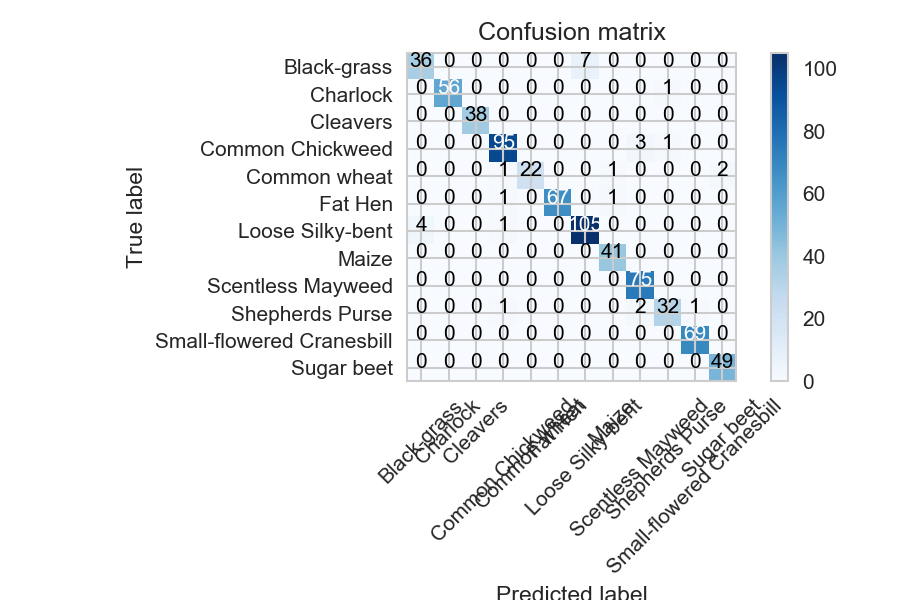

Confusion matrix, without normalization


In [21]:
confusion_diagnostic(model)